# Phase 1: Data Preparation (Number of classes=15)
# Phase 2: SIFT+BOW,  ORB+BOW  
#          SIFT+Fisher Vector, ORB+Fisher Vector 
#          SVM, Evaluation(Classification Report)

# ------------ Importing All Important Libraries -------------

In [95]:
import os
import random
import shutil
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.decomposition import PCA

# All necessary functions to prepare data, extracting image local features by SIFT,ORB
# Middle Level features by BOW,Fisher Vector
# Training & Evaluation SVM

In [97]:
# ---------------------
# Utility Functions
# ---------------------

def clean_folder_name(folder_name):
    """
    Clean folder names by stripping special characters like tabs or whitespace.
    """
    return folder_name.strip()


def load_class_names(class_name_file):
    """
    Load class names from the class_name.txt file, handling multiple labels.
    """
    class_dict = {}
    with open(class_name_file, "r") as f:
        for line_num, line in enumerate(f, start=1):
            parts = line.strip().split("\t")  # Split by tabs
            if len(parts) < 2:
                print(f"Warning: Skipping line {line_num} due to unexpected format: {line.strip()}")
                continue
            folder = clean_folder_name(parts[0])  # Folder name
            labels = [label.strip() for label in parts[1].split(",")]  # Keep all labels
            class_dict[folder] = labels
    return class_dict
def concatenate_labels(class_dict, selected_classes):
    """
    Concatenate all labels for each selected class into a single string.
    """
    concatenated_labels = []
    for cls in selected_classes:
        if cls in class_dict:
            concatenated_labels.append(", ".join(class_dict[cls]))
        else:
            concatenated_labels.append(f"Unknown-{cls}")
    return concatenated_labels


def visualize_class_distribution(train_path, test_path):
    """
    Visualize the number of images per class in the train and test datasets.
    """
    train_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in os.listdir(train_path)}
    test_counts = {cls: len(os.listdir(os.path.join(test_path, cls))) for cls in os.listdir(test_path)}

    plt.figure(figsize=(15, 5))
    plt.bar(train_counts.keys(), train_counts.values(), alpha=0.7, label="Train")
    plt.bar(test_counts.keys(), test_counts.values(), alpha=0.7, label="Test")
    plt.xticks(rotation=90)
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ---------------------
# Dataset Preparation
# ---------------------

def prepare_dataset_with_labels(tinyimagenet_path, output_path, class_name_file, num_classes=15, seed=50):
    """
    Prepares a dataset with labels for training and testing.
    """
    random.seed(seed)
    class_dict = load_class_names(class_name_file)
    class_dict = {clean_folder_name(k): v for k, v in class_dict.items()}

    all_folders = [
        clean_folder_name(f) for f in os.listdir(tinyimagenet_path)
        if os.path.isdir(os.path.join(tinyimagenet_path, f)) and not f.startswith(".")
    ]

    selected_classes = random.sample(all_folders, min(num_classes, len(all_folders)))

    train_path = os.path.join(output_path, "train")
    test_path = os.path.join(output_path, "test")
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    for class_name in tqdm(selected_classes, desc="Preparing dataset"):
        class_path = os.path.join(tinyimagenet_path, class_name, "images")
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} does not exist. Skipping...")
            continue

        images = sorted(os.listdir(class_path))
        train_images = images[:400]
        test_images = images[400:500]

        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        for img_name in train_images:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(train_class_path, img_name))
        for img_name in test_images:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(test_class_path, img_name))

    visualize_class_distribution(train_path, test_path)
    return selected_classes


# ---------------------
# Feature Extraction
# ---------------------

def extract_features_sift(image_paths):
    sift = cv2.SIFT_create()
    descriptors_list = []
    for img_path in tqdm(image_paths, desc="Extracting SIFT features"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list


'''def extract_features_orb(image_paths):
    orb = cv2.ORB_create(nfeatures=500)
    descriptors_list = []
    for img_path in tqdm(image_paths, desc="Extracting ORB features"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, descriptors = orb.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list'''
def extract_features_orb(image_paths, nfeatures=2000):
    """
    Extract ORB features from a list of image paths.

    Args:
        image_paths (list): List of image paths.
        nfeatures (int): Maximum number of keypoints to detect per image.

    Returns:
        list: List of ORB descriptors for all images.
    """
    orb = cv2.ORB_create(nfeatures=nfeatures)
    descriptors_list = []
    for img_path in tqdm(image_paths, desc="Extracting ORB features"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to load image {img_path}")
            continue
        _, descriptors = orb.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
        else:
            descriptors_list.append(np.zeros((1, 32)))  # Placeholder for missing descriptors
    return descriptors_list


'''def build_bow(descriptors_list, num_clusters):
    all_descriptors = np.vstack(descriptors_list).astype(np.float32)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans'''

def build_bow(descriptors_list, num_clusters):
    """
    Build a Bag of Words (BoW) model using KMeans.
    Normalizes binary ORB descriptors and processes SIFT descriptors as-is.
    """
    # Stack all descriptors into a single array
    all_descriptors = np.vstack(descriptors_list).astype(np.float32)

    # Normalize descriptors (only affects ORB, but works safely for SIFT too)
    all_descriptors /= np.linalg.norm(all_descriptors, axis=1, keepdims=True) + 1e-6

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans



def encode_features(image_paths, kmeans, method="SIFT"):
    features = []
    if method == "SIFT":
        detector = cv2.SIFT_create()
    elif method == "ORB":
        detector = cv2.ORB_create(nfeatures=500)
    else:
        raise ValueError("Unsupported method. Choose 'SIFT' or 'ORB'.")

    for path in tqdm(image_paths, desc=f"Encoding images with {method}"):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        _, descriptors = detector.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors = descriptors.astype(np.float32)
            histogram = np.zeros(len(kmeans.cluster_centers_))
            clusters = kmeans.predict(descriptors)
            for cluster in clusters:
                histogram[cluster] += 1
            features.append(histogram)
        else:
            features.append(np.zeros(len(kmeans.cluster_centers_)))
    return np.array(features)


# ---------------------
# Fisher Vector
# ---------------------

def train_fisher_gmm(descriptors_list, num_clusters):
    """
    Train a Gaussian Mixture Model (GMM) for Fisher Vector computation.
    Filters descriptors with incorrect dimensions.
    """
    # Filter valid descriptors (with dimension 128)
    valid_descriptors = [desc for desc in descriptors_list if desc is not None and desc.shape[1] == 128]
    if len(valid_descriptors) == 0:
        raise ValueError("No valid descriptors found. Check your dataset or feature extraction process.")

    # Stack valid descriptors
    all_descriptors = np.vstack(valid_descriptors).astype(np.float32)
    print(f"Training GMM with {all_descriptors.shape[0]} descriptors of dimension {all_descriptors.shape[1]}...")
    
    # Train GMM
    gmm = GaussianMixture(n_components=num_clusters, covariance_type="diag", random_state=42, max_iter=100)
    gmm.fit(all_descriptors)
    return gmm

def compute_fisher_vector(descriptors_list, gmm):
    """
    Compute Fisher Vector representation for a list of descriptors using a GMM model.
    Assign zero vectors for missing descriptors.
    """
    fisher_vectors = []
    zero_vector = np.zeros(gmm.n_components * 2 * gmm.means_.shape[1])  # Zero vector for missing descriptors
    for descriptors in tqdm(descriptors_list, desc="Computing Fisher Vectors"):
        if descriptors is None or len(descriptors) == 0:
            fisher_vectors.append(zero_vector)  # Assign a zero vector for missing descriptors
        else:
            fisher_vector = np.hstack([
                np.sum((descriptors - mean) / cov, axis=0)
                for mean, cov in zip(gmm.means_, gmm.covariances_)
            ])
            fisher_vectors.append(fisher_vector)
    return np.array(fisher_vectors)


# ---------------------
# SVM Training and Evaluation
# ---------------------

def train_and_evaluate_svm(X_train, X_test, y_train, y_test, class_dict, selected_classes):
    # Get concatenated labels for evaluation
    selected_labels = concatenate_labels(class_dict, selected_classes)
    print("Selected Labels:", selected_labels)

   # if len(set(y_train)) != len(selected_labels):
    #    print(f"Error: Mismatch between the number of classes ({len(set(y_train))}) and labels ({len(selected_labels)})")
    #    return

    print("Training SVM...")
    #svm = LinearSVC(random_state=42)
    svm = LinearSVC(random_state=42, C=1.0, max_iter=10000)  # Adjust max_iter for convergence
    svm.fit(X_train, y_train)

    predictions = svm.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=selected_labels))

    print("Confusion Matrix:")
    plot_confusion_matrix(y_test, predictions, selected_labels)


def plot_confusion_matrix(y_test, predictions, labels):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()


# ---------------------Visualization Functions---------------------

In [99]:
def visualize_sift_keypoints(image_paths, num_images=5):
    """
    Visualize SIFT keypoints for a few sample images.
    Handles missing or invalid images gracefully.
    """
    sift = cv2.SIFT_create()
    plt.figure(figsize=(15, 10))
    valid_images = 0  # Counter for valid images
    for img_path in image_paths:
        if valid_images >= num_images:
            break  # Stop after visualizing num_images

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to load image at {img_path}. Skipping...")
            continue  # Skip invalid or missing images

        keypoints, _ = sift.detectAndCompute(img, None)
        img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.subplot(1, num_images, valid_images + 1)
        plt.imshow(img_with_keypoints, cmap="gray")
        plt.title(f"Image {valid_images + 1} - SIFT Keypoints")
        plt.axis("off")
        valid_images += 1  # Increment valid image counter

    if valid_images == 0:
        print("No valid images to visualize.")
    else:
        plt.tight_layout()
        plt.show()

def visualize_orb_keypoints(image_paths, num_images=5):
    """
    Visualize ORB keypoints for a few sample images.
    Handles missing or invalid images gracefully.
    """
    orb = cv2.ORB_create(nfeatures=500)  # Create ORB detector
    plt.figure(figsize=(15, 10))
    valid_images = 0  # Counter for valid images
    for img_path in image_paths:
        if valid_images >= num_images:
            break  # Stop after visualizing num_images

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to load image at {img_path}. Skipping...")
            continue  # Skip invalid or missing images

        keypoints, _ = orb.detectAndCompute(img, None)
        img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.subplot(1, num_images, valid_images + 1)
        plt.imshow(img_with_keypoints, cmap="gray")
        plt.title(f"Image {valid_images + 1} - ORB Keypoints")
        plt.axis("off")
        valid_images += 1  # Increment valid image counter

    if valid_images == 0:
        print("No valid images to visualize.")
    else:
        plt.tight_layout()
        plt.show()



def visualize_bow_histograms(image_paths, kmeans, num_images=5, method="SIFT"):
    """
    Visualize BoW histograms for a few sample images.
    """
    detector = cv2.SIFT_create() if method == "SIFT" else cv2.ORB_create(nfeatures=500)
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, descriptors = detector.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors = descriptors.astype(np.float32)
            histogram = np.zeros(len(kmeans.cluster_centers_))
            clusters = kmeans.predict(descriptors)
            for cluster in clusters:
                histogram[cluster] += 1
        else:
            histogram = np.zeros(len(kmeans.cluster_centers_))
        plt.subplot(1, num_images, i + 1)
        plt.bar(range(len(histogram)), histogram)
        plt.title(f"Image {i+1} - BoW Histogram")
        plt.xlabel("Cluster")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# --------------------- Main Workflow ---------------------

** Loading prepared_dataset in which train and test folders of randomly selected 15 classes are there **

Preparing dataset: 100%|████████████████████████| 15/15 [00:00<00:00, 16.16it/s]


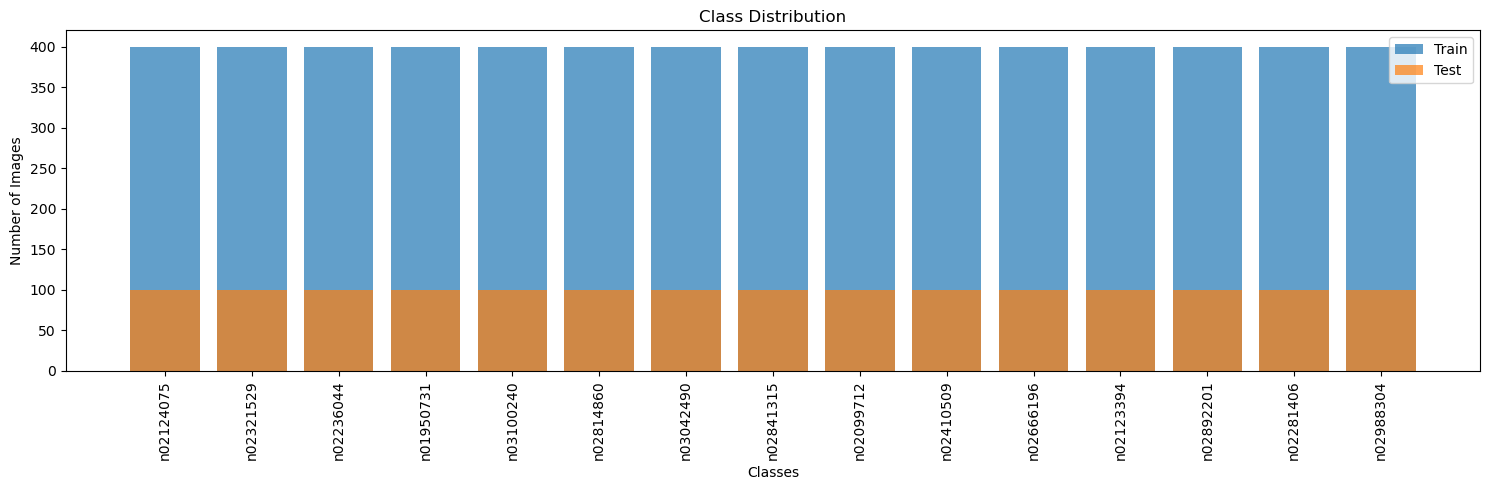

In [101]:
# Data preparation
tinyimagenet_path = "TinyImageNet100"
output_path = "./prepared_dataset2"
class_name_file = os.path.join(tinyimagenet_path, "class_name.txt")

# Prepare dataset
selected_classes = prepare_dataset_with_labels(tinyimagenet_path, output_path, class_name_file)


# ----------------Load train and test image paths and labels----------------

In [103]:
selected_classes

['n02099712',
 'n01950731',
 'n03042490',
 'n02123394',
 'n02236044',
 'n02281406',
 'n02841315',
 'n02988304',
 'n02814860',
 'n02124075',
 'n02410509',
 'n03100240',
 'n02321529',
 'n02892201',
 'n02666196']

In [105]:

def load_image_paths_and_labels(data_path):
    image_paths = []
    labels = []
    classes = os.listdir(data_path)
    for label, cls in enumerate(classes):
        cls_path = os.path.join(data_path, cls)
        images = [os.path.join(cls_path, img) for img in os.listdir(cls_path)]
        image_paths.extend(images)
        labels.extend([label] * len(images))
    return image_paths, labels


train_path = os.path.join(output_path, "train")
test_path = os.path.join(output_path, "test")
train_image_paths, train_labels = load_image_paths_and_labels(train_path)
test_image_paths, test_labels = load_image_paths_and_labels(test_path)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(test_labels)

# Load class dictionary
class_dict = load_class_names(class_name_file)
class_dict = {clean_folder_name(k): v for k, v in class_dict.items()}


# ------------Workflow with BOW+SIFT and BOW+ORB------------------------


Running workflow using SIFT and BoW...


Encoding images with SIFT: 100%|██████████| 1500/1500 [00:00<00:00, 1577.55it/s]


Visualizing SIFT keypoints for a few training images...


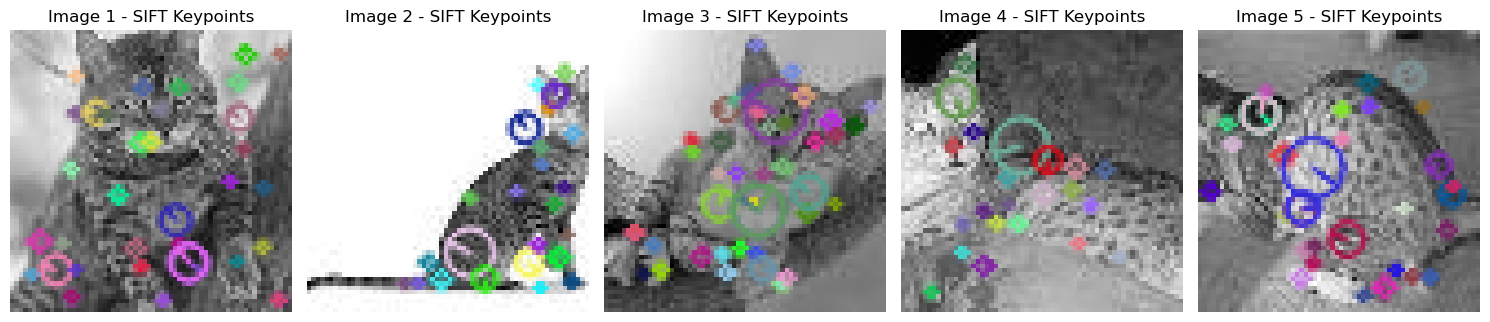

Visualizing BoW histograms for a few training images using SIFT...


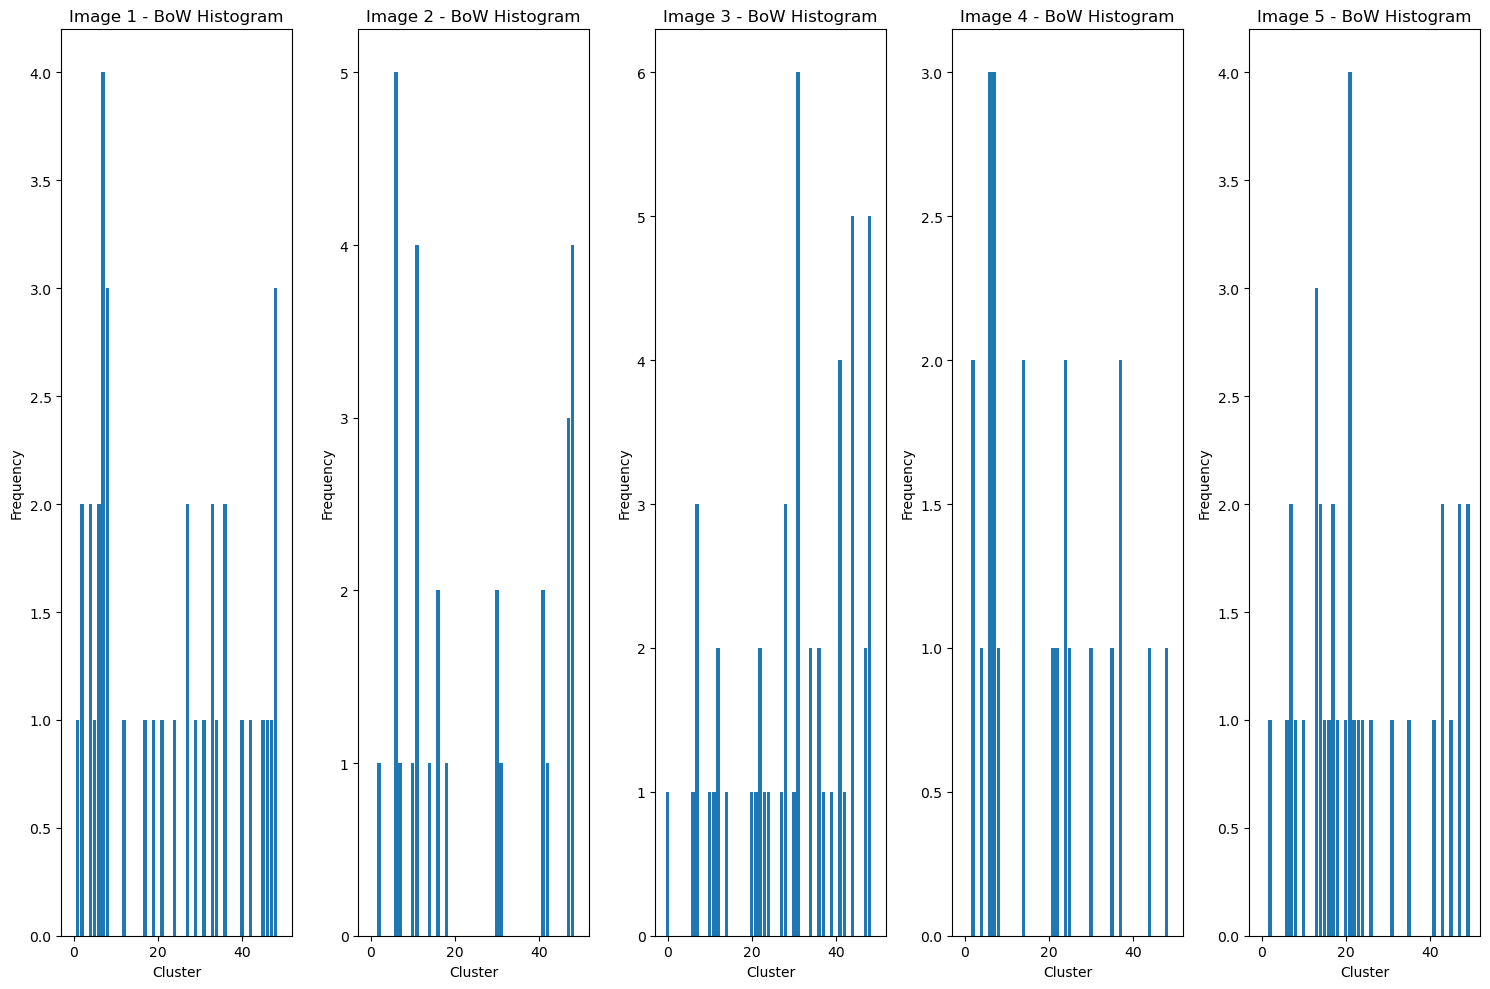

Selected Labels: ['Labrador retriever', 'sea slug, nudibranch', 'cliff dwelling', 'Persian cat', 'mantis, mantid', 'sulphur butterfly, sulfur butterfly', 'binoculars, field glasses, opera glasses', 'CD player', 'beacon, lighthouse, beacon light, pharos', 'Egyptian cat', 'bison', 'convertible', 'sea cucumber, holothurian', 'brass, memorial tablet, plaque', 'abacus']
Training SVM...
Classification Report:
                                          precision    recall  f1-score   support

                      Labrador retriever       0.17      0.07      0.10       100
                    sea slug, nudibranch       0.24      0.07      0.11       100
                          cliff dwelling       0.16      0.13      0.14       100
                             Persian cat       0.19      0.30      0.23       100
                          mantis, mantid       0.23      0.33      0.27       100
     sulphur butterfly, sulfur butterfly       0.18      0.33      0.23       100
binoculars, field 

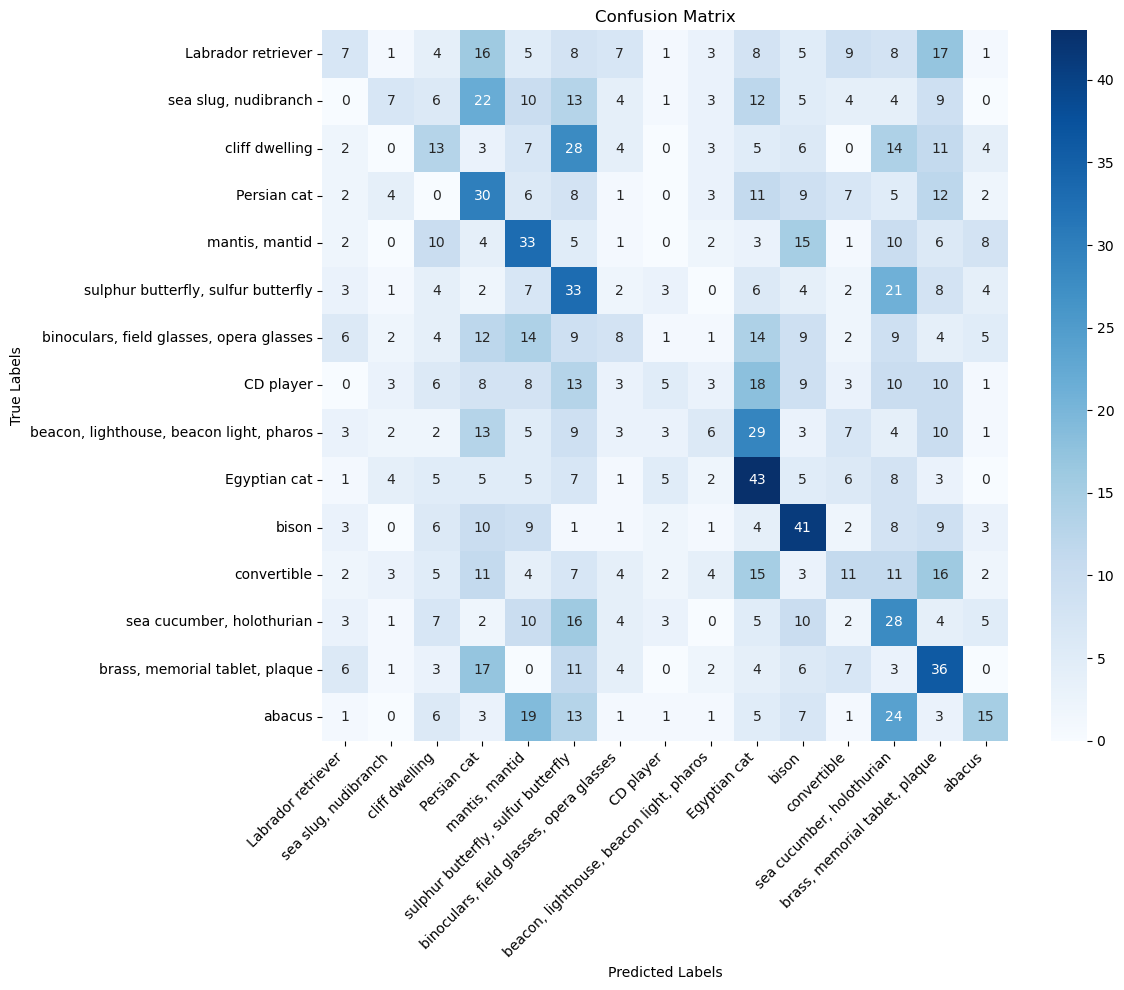


Running workflow using ORB and BoW...


Encoding images with ORB: 100%|███████████| 1500/1500 [00:00<00:00, 6168.70it/s]


Visualizing ORB keypoints for a few training images...


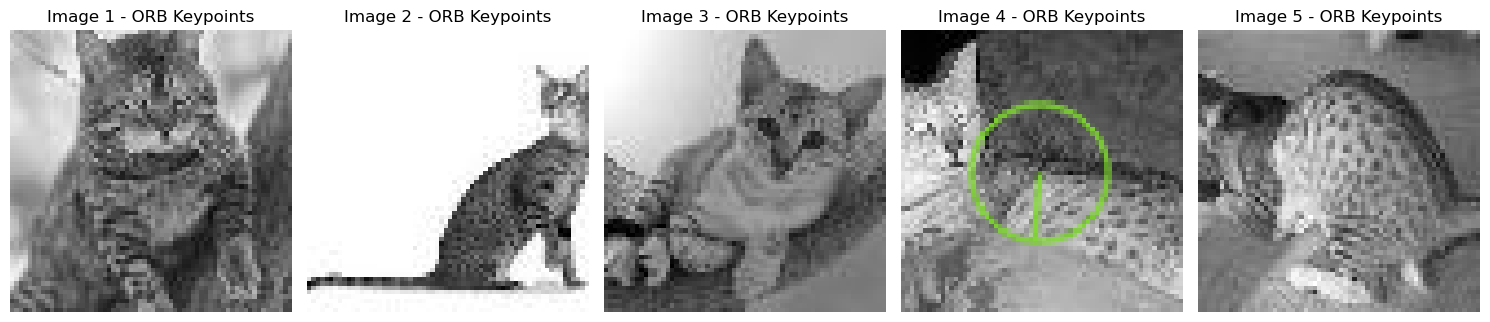

Visualizing BoW histograms for a few training images using ORB...


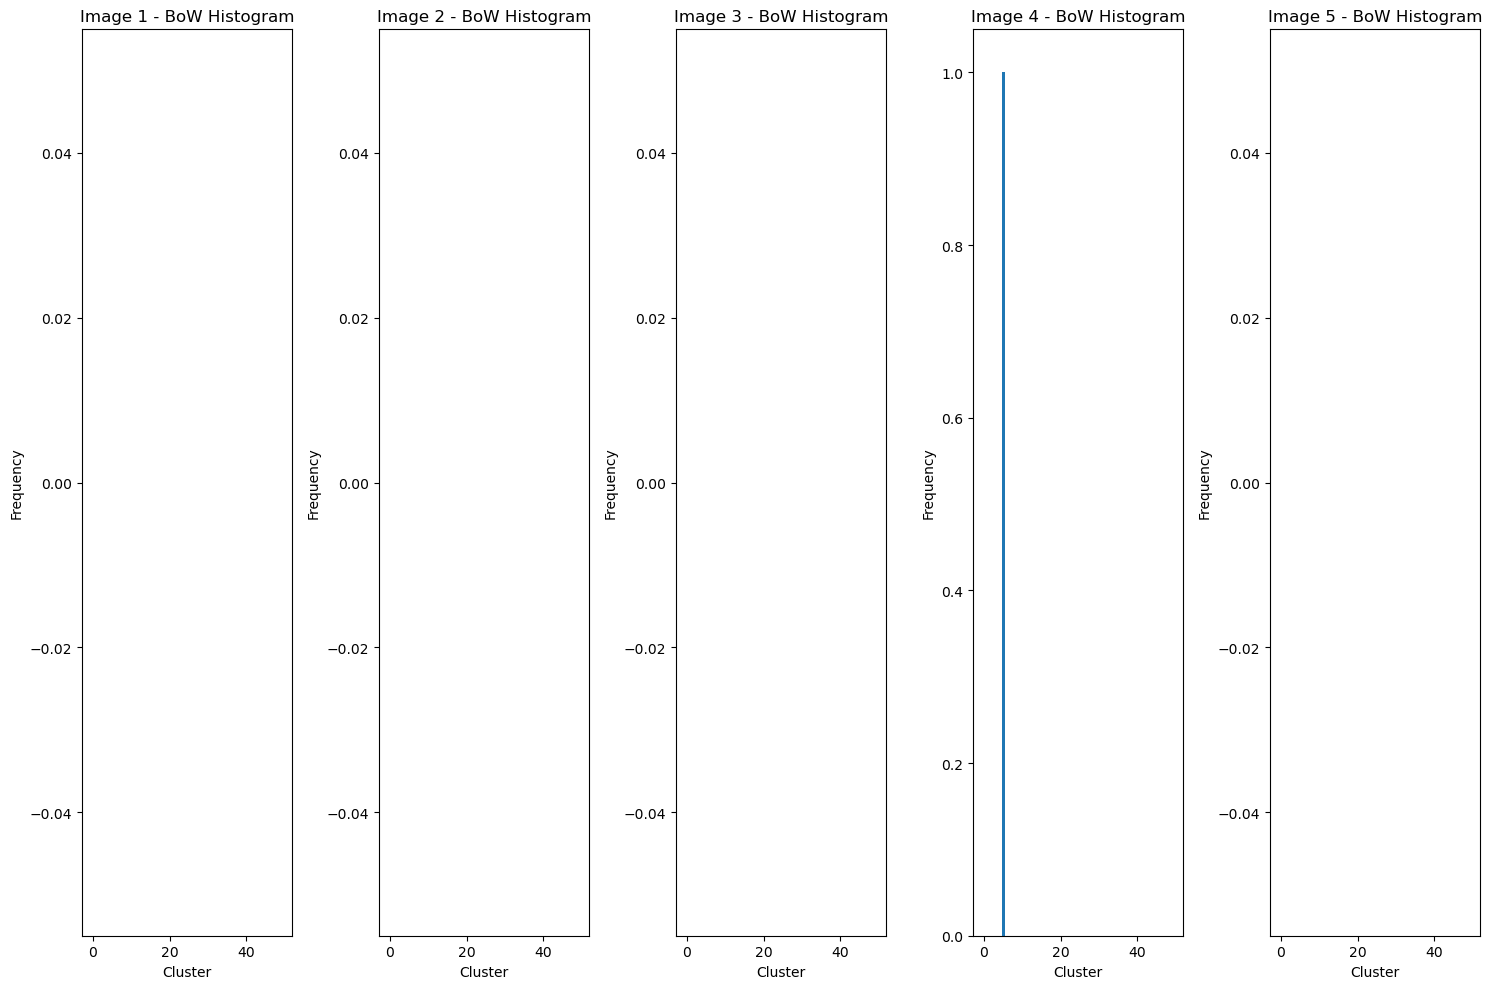

Selected Labels: ['Labrador retriever', 'sea slug, nudibranch', 'cliff dwelling', 'Persian cat', 'mantis, mantid', 'sulphur butterfly, sulfur butterfly', 'binoculars, field glasses, opera glasses', 'CD player', 'beacon, lighthouse, beacon light, pharos', 'Egyptian cat', 'bison', 'convertible', 'sea cucumber, holothurian', 'brass, memorial tablet, plaque', 'abacus']
Training SVM...
Classification Report:
                                          precision    recall  f1-score   support

                      Labrador retriever       0.25      0.01      0.02       100
                    sea slug, nudibranch       0.08      0.01      0.02       100
                          cliff dwelling       0.12      0.04      0.06       100
                             Persian cat       0.00      0.00      0.00       100
                          mantis, mantid       0.11      0.01      0.02       100
     sulphur butterfly, sulfur butterfly       0.08      0.90      0.14       100
binoculars, field 

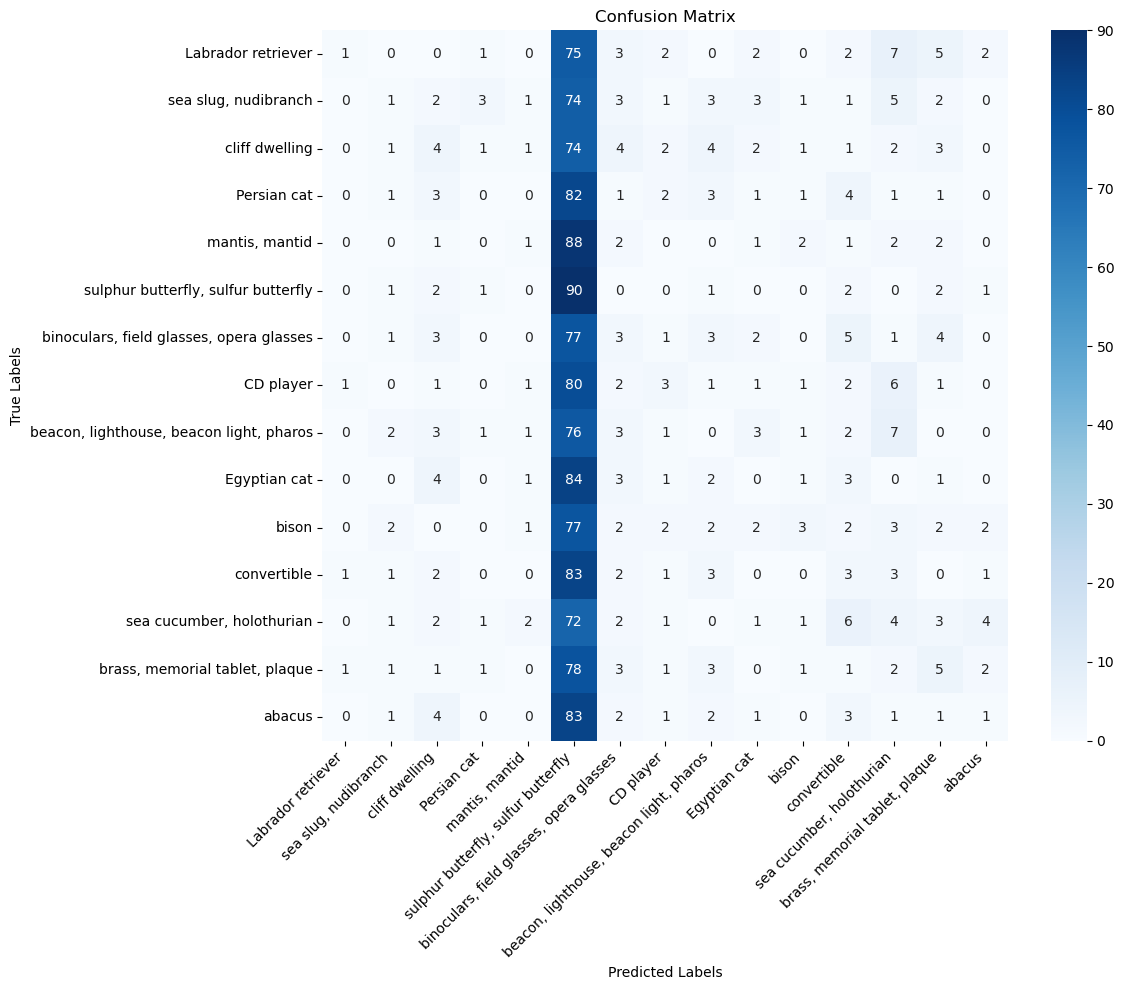

In [107]:
# BoW workflow
for method in ["SIFT", "ORB"]:
    print(f"\nRunning workflow using {method} and BoW...")

    # Extract descriptors
    descriptors_train = extract_features_sift(train_image_paths) if method == "SIFT" else extract_features_orb(train_image_paths)
    descriptors_test = extract_features_sift(test_image_paths) if method == "SIFT" else extract_features_orb(test_image_paths)

    # Build BoW model
    num_clusters = 50 #if method == "SIFT" else 200  # Use a higher number of clusters for ORB
    kmeans = build_bow(descriptors_train, num_clusters=num_clusters)

    # Encode features
    X_train = encode_features(train_image_paths, kmeans, method=method)
    X_test = encode_features(test_image_paths, kmeans, method=method)

    # Visualize Keypoints
    if method == "SIFT":
        print("Visualizing SIFT keypoints for a few training images...")
        visualize_sift_keypoints(train_image_paths, num_images=5)
    else:
        print("Visualizing ORB keypoints for a few training images...")
        visualize_orb_keypoints(train_image_paths, num_images=5)

    # Visualize BoW Histograms
    print(f"Visualizing BoW histograms for a few training images using {method}...")
    visualize_bow_histograms(train_image_paths, kmeans, num_images=5, method=method)

    # Train and Evaluate SVM
    train_and_evaluate_svm(X_train, X_test, y_train, y_test, class_dict, selected_classes)


# Please scroll down to see the whole output (classification report for SIFT and ORB) 


# ----------Checking descriptors generated by ORB--------As accuracy is low----

In [109]:
descriptors_train_orb = extract_features_orb(train_image_paths)
for i, desc in enumerate(descriptors_train_orb[:5]):
    print(f"Image {i}: Descriptor shape: {desc.shape}")


Extracting ORB features: 100%|████████████| 6000/6000 [00:00<00:00, 6393.66it/s]

Image 0: Descriptor shape: (1, 32)
Image 1: Descriptor shape: (1, 32)
Image 2: Descriptor shape: (1, 32)
Image 3: Descriptor shape: (1, 32)
Image 4: Descriptor shape: (1, 32)


In [111]:
kmeans_orb = build_bow(descriptors_train_orb, num_clusters=200)

# Print a few cluster centers
print("Sample cluster centers (ORB):")
print(kmeans_orb.cluster_centers_[:5])

Sample cluster centers (ORB):
[[ 1.26659870e-07  7.07805157e-08 -1.41561031e-07 -1.49011612e-08
   5.21540642e-08  9.31322575e-08 -1.04308128e-07  7.82310963e-08
   7.45058060e-09  7.07805157e-08  3.72529030e-09 -1.30385160e-08
   7.45058060e-09 -4.84287739e-08  7.07805157e-08  5.21540642e-08
  -7.45058060e-08 -1.30385160e-07  5.58793545e-08  8.19563866e-08
   1.04308128e-07 -1.22934580e-07  1.67638063e-07  1.22934580e-07
   6.70552254e-08  1.60187483e-07 -6.33299351e-08 -6.33299351e-08
   1.86264515e-08 -1.67638063e-07  2.45869160e-07  5.96046448e-08]
 [ 1.34675264e-01  2.11112067e-01  1.61930844e-01  1.78012118e-01
   2.12181032e-01  1.79723755e-01  1.15503810e-01  1.32352769e-01
   1.77377179e-01  2.35639036e-01  1.13431796e-01  2.24640712e-01
   1.89756259e-01  2.24770248e-01  1.72369033e-01  7.51729086e-02
   1.10921994e-01  2.17280179e-01  1.22502789e-01  2.25898266e-01
   1.77654386e-01  1.13509178e-01  2.06157237e-01  1.42310292e-01
   2.03168526e-01  1.60832882e-01  9.56200808

# Increasing number of Clusters(70 from 50) to Check/Improve Performance


Running workflow using SIFT and BoW...


Encoding images with SIFT: 100%|██████████| 1500/1500 [00:00<00:00, 1509.23it/s]


Visualizing SIFT keypoints for a few training images...


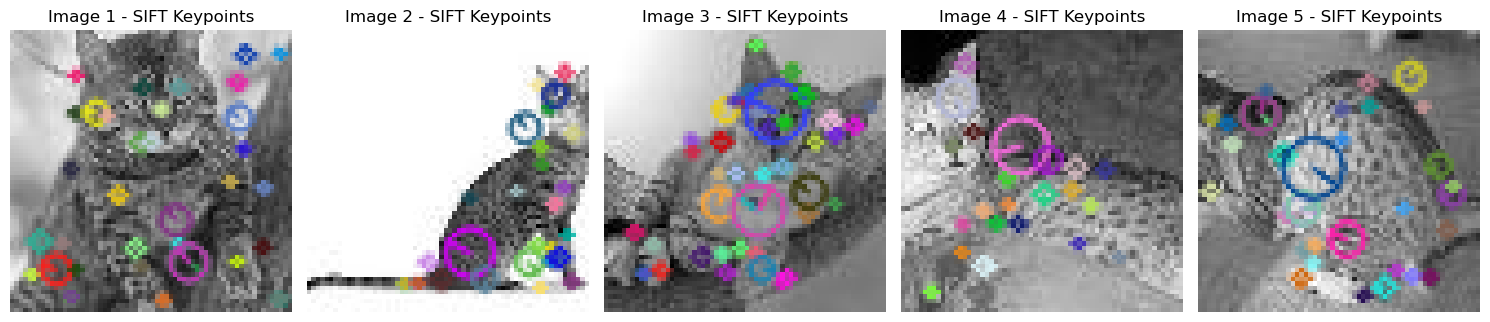

Visualizing BoW histograms for a few training images using SIFT...


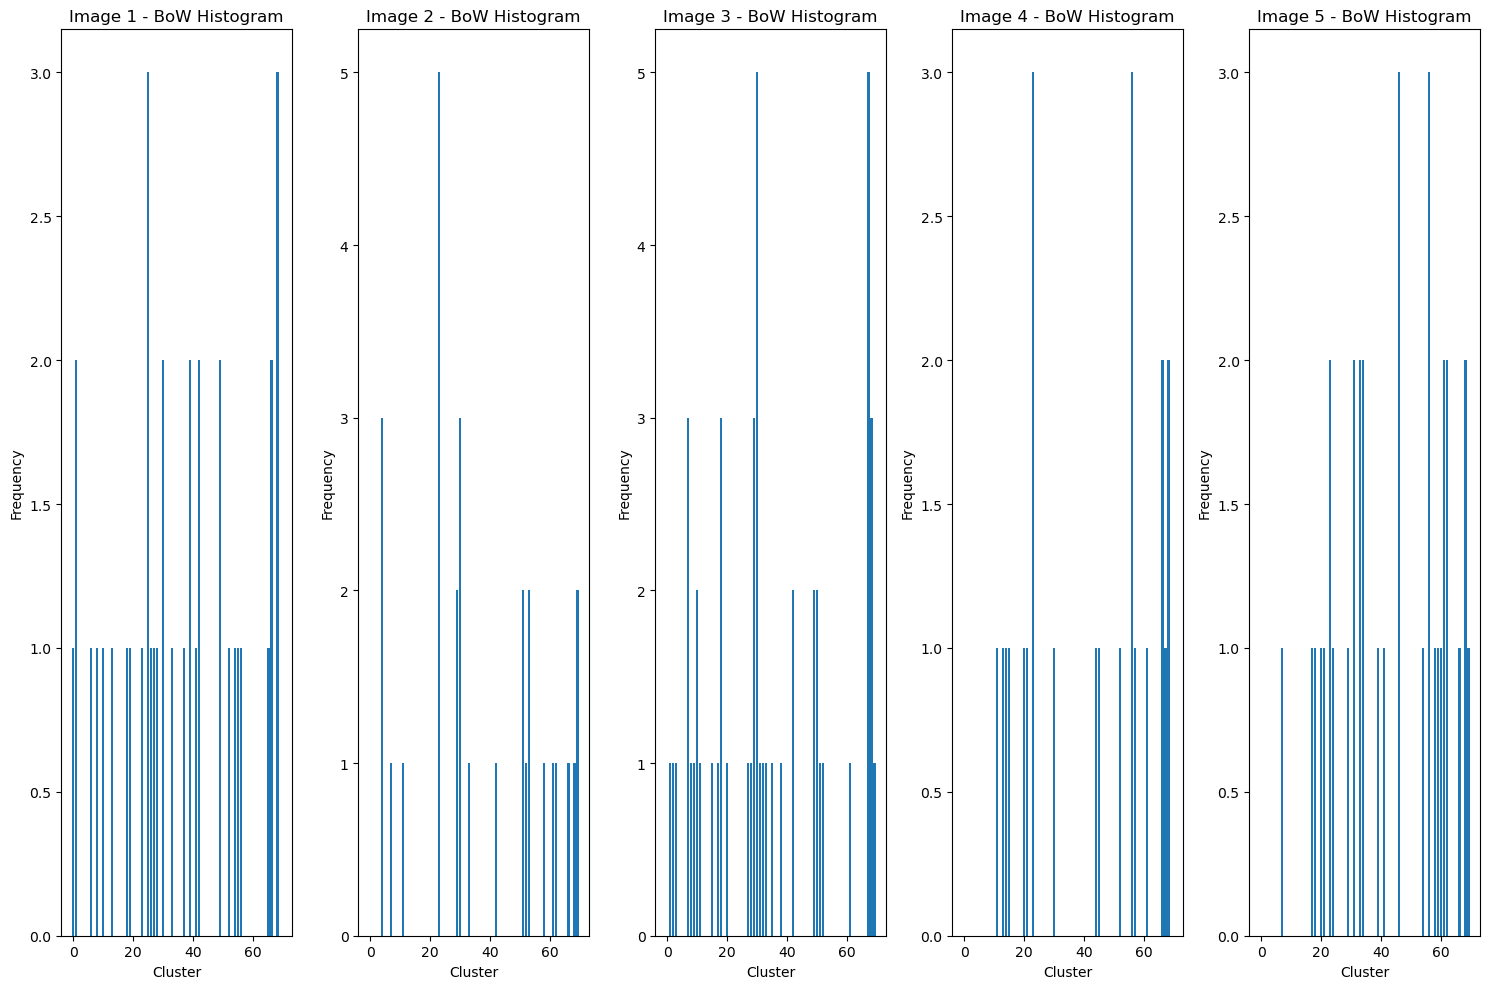

Selected Labels: ['Labrador retriever', 'sea slug, nudibranch', 'cliff dwelling', 'Persian cat', 'mantis, mantid', 'sulphur butterfly, sulfur butterfly', 'binoculars, field glasses, opera glasses', 'CD player', 'beacon, lighthouse, beacon light, pharos', 'Egyptian cat', 'bison', 'convertible', 'sea cucumber, holothurian', 'brass, memorial tablet, plaque', 'abacus']
Training SVM...
Classification Report:
                                          precision    recall  f1-score   support

                      Labrador retriever       0.24      0.10      0.14       100
                    sea slug, nudibranch       0.28      0.11      0.16       100
                          cliff dwelling       0.21      0.16      0.18       100
                             Persian cat       0.23      0.34      0.28       100
                          mantis, mantid       0.26      0.35      0.30       100
     sulphur butterfly, sulfur butterfly       0.19      0.34      0.25       100
binoculars, field 

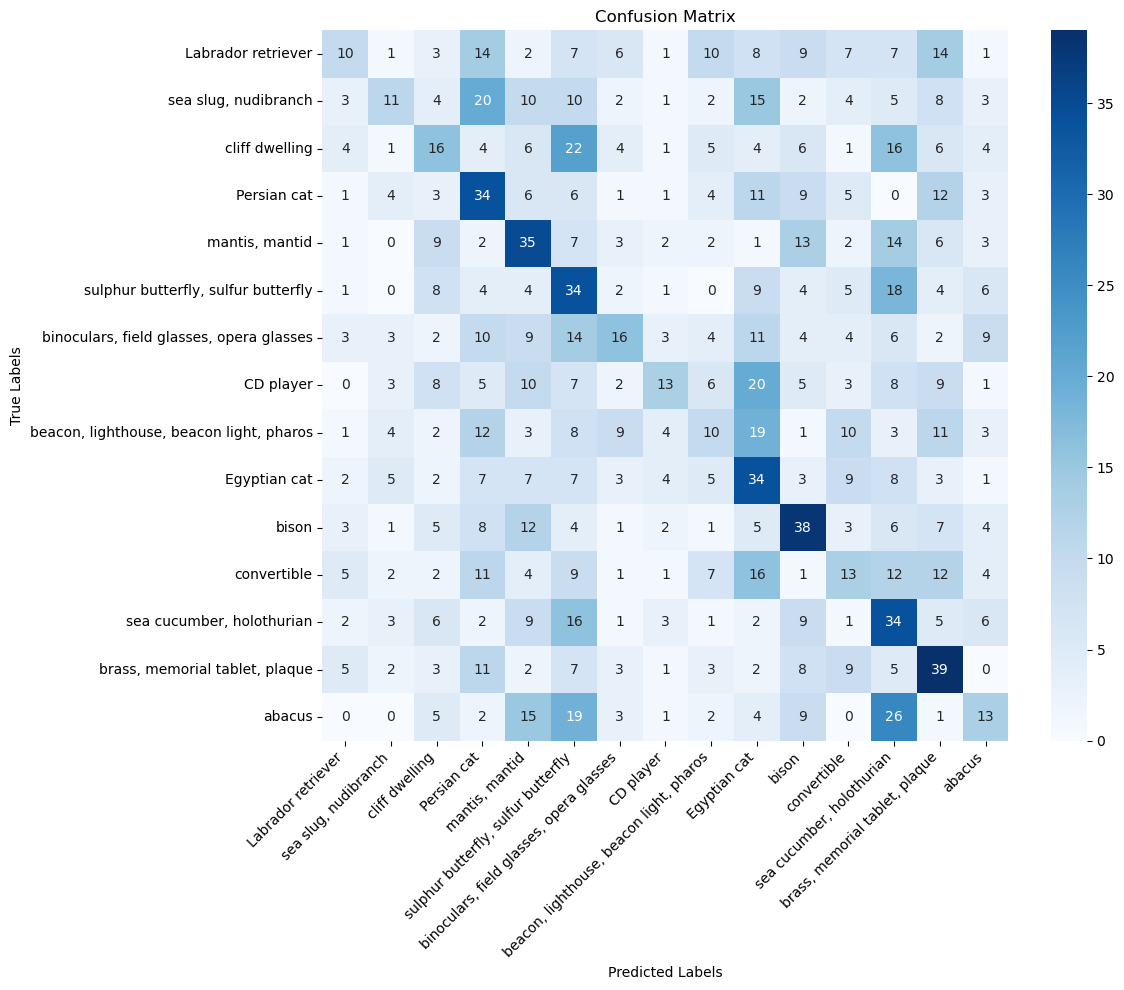


Running workflow using ORB and BoW...


Encoding images with ORB: 100%|███████████| 1500/1500 [00:00<00:00, 6108.51it/s]


Visualizing ORB keypoints for a few training images...


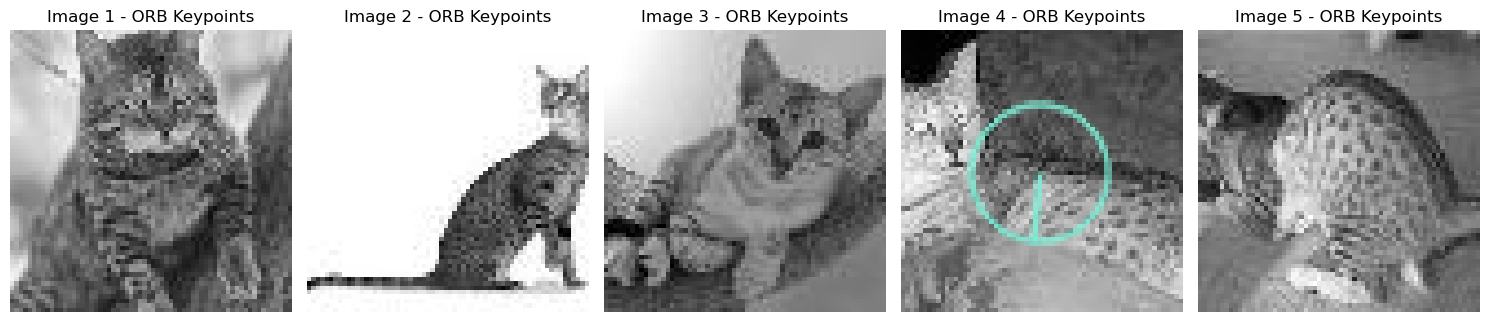

Visualizing BoW histograms for a few training images using ORB...


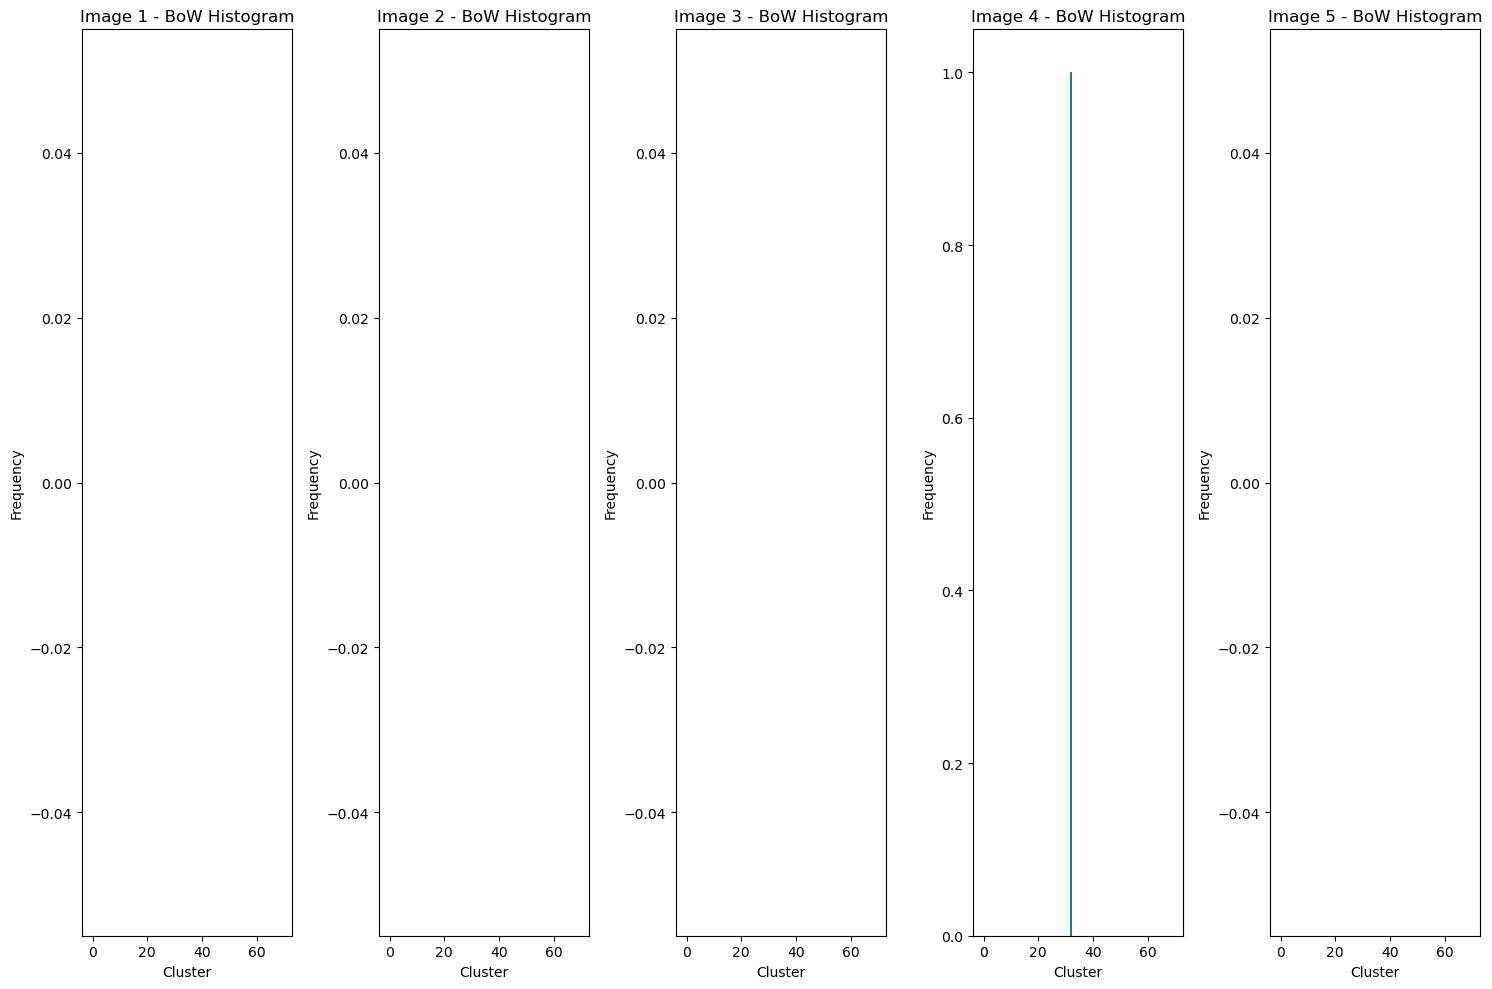

Selected Labels: ['Labrador retriever', 'sea slug, nudibranch', 'cliff dwelling', 'Persian cat', 'mantis, mantid', 'sulphur butterfly, sulfur butterfly', 'binoculars, field glasses, opera glasses', 'CD player', 'beacon, lighthouse, beacon light, pharos', 'Egyptian cat', 'bison', 'convertible', 'sea cucumber, holothurian', 'brass, memorial tablet, plaque', 'abacus']
Training SVM...
Classification Report:
                                          precision    recall  f1-score   support

                      Labrador retriever       0.16      0.05      0.08       100
                    sea slug, nudibranch       0.03      0.01      0.02       100
                          cliff dwelling       0.00      0.00      0.00       100
                             Persian cat       0.00      0.00      0.00       100
                          mantis, mantid       0.09      0.02      0.03       100
     sulphur butterfly, sulfur butterfly       0.08      0.91      0.14       100
binoculars, field 

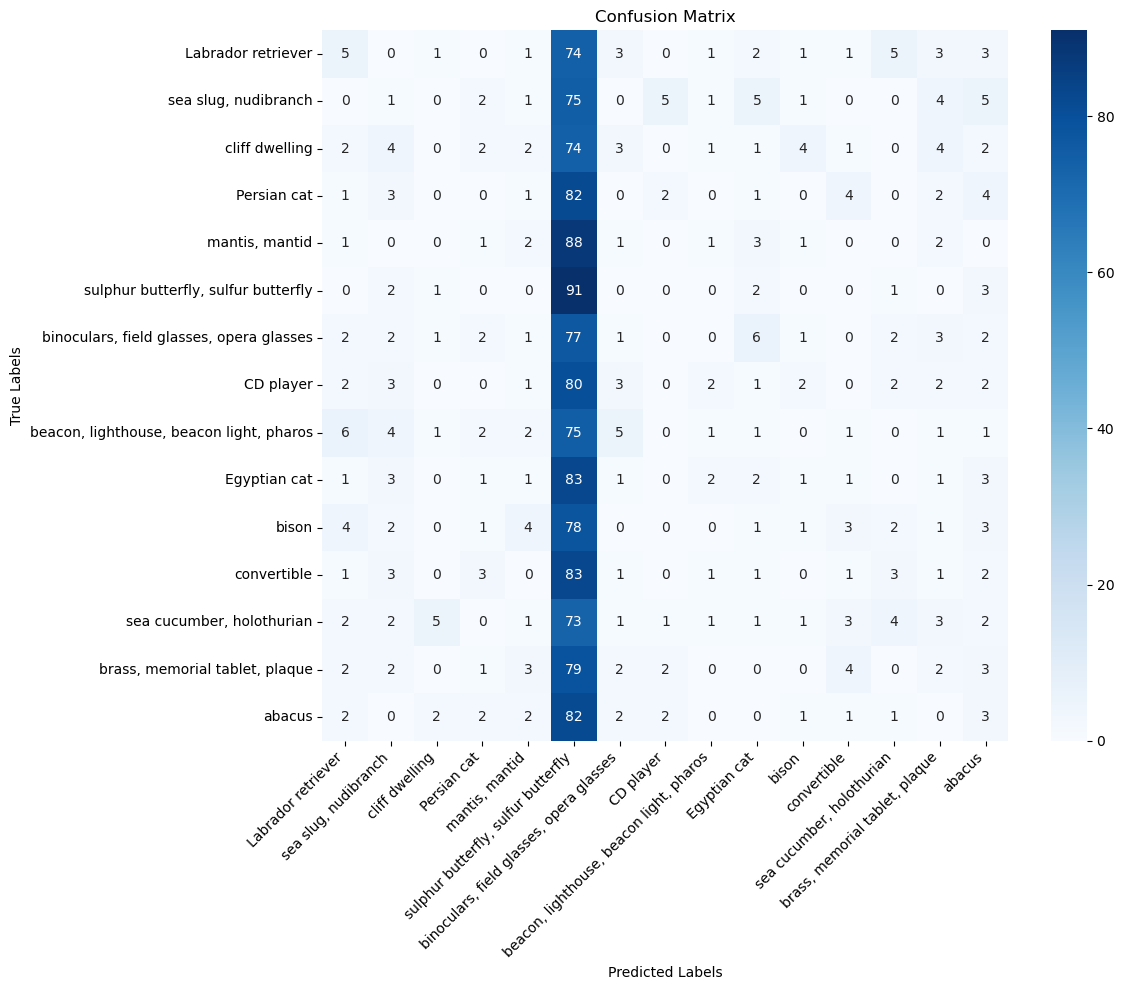

In [113]:
# BoW workflow
for method in ["SIFT", "ORB"]:
    print(f"\nRunning workflow using {method} and BoW...")
    descriptors_train = extract_features_sift(train_image_paths) if method == "SIFT" else extract_features_orb(train_image_paths)
    descriptors_test = extract_features_sift(test_image_paths) if method == "SIFT" else extract_features_orb(test_image_paths)



    kmeans = build_bow(descriptors_train, num_clusters=70)
    X_train = encode_features(train_image_paths, kmeans, method=method)
    X_test = encode_features(test_image_paths, kmeans, method=method)
    
     # Visualize SIFT Keypoints for SIFT method
    if method == "SIFT":
        print("Visualizing SIFT keypoints for a few training images...")
        visualize_sift_keypoints(train_image_paths, num_images=5)
    else:
    # Visualize ORB Keypoints
        print("Visualizing ORB keypoints for a few training images...")
        visualize_orb_keypoints(train_image_paths, num_images=5)

    # Visualize BoW Histograms
    print(f"Visualizing BoW histograms for a few training images using {method}...")
    visualize_bow_histograms(train_image_paths, kmeans, num_images=5, method=method)
   

    train_and_evaluate_svm(X_train, X_test, y_train, y_test, class_dict, selected_classes)


# Trying to change the number of features from 500(by default) to 2000 for ORB only

In [115]:
def preprocess_image(img):
    # Apply histogram equalization
    img = cv2.equalizeHist(img)
    return img

def extract_features_orb1(image_paths, nfeatures=2000):
    orb = cv2.ORB_create(nfeatures=nfeatures)
    descriptors_list = []
    for img_path in tqdm(image_paths, desc="Extracting ORB features"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to load image {img_path}")
            continue

        # Preprocess the image
        img = preprocess_image(img)
        
        _, descriptors = orb.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
        else:
            descriptors_list.append(np.zeros((1, 32)))  # Placeholder for missing descriptors
    return descriptors_list


In [117]:
def visualize_orb_keypoints_debug(image_paths, num_images=5):
    orb = cv2.ORB_create(nfeatures=2000)
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to load image {img_path}")
            continue
        keypoints, _ = orb.detectAndCompute(img, None)
        img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_with_keypoints, cmap="gray")
        plt.title(f"Image {i}: {len(keypoints)} keypoints")
        plt.axis("off")
    plt.tight_layout()
    plt.show()



Running workflow using SIFT and BoW...


Extracting SIFT features: 100%|███████████| 1500/1500 [00:01<00:00, 1429.39it/s]


Visualizing ORB keypoints for a few training images...


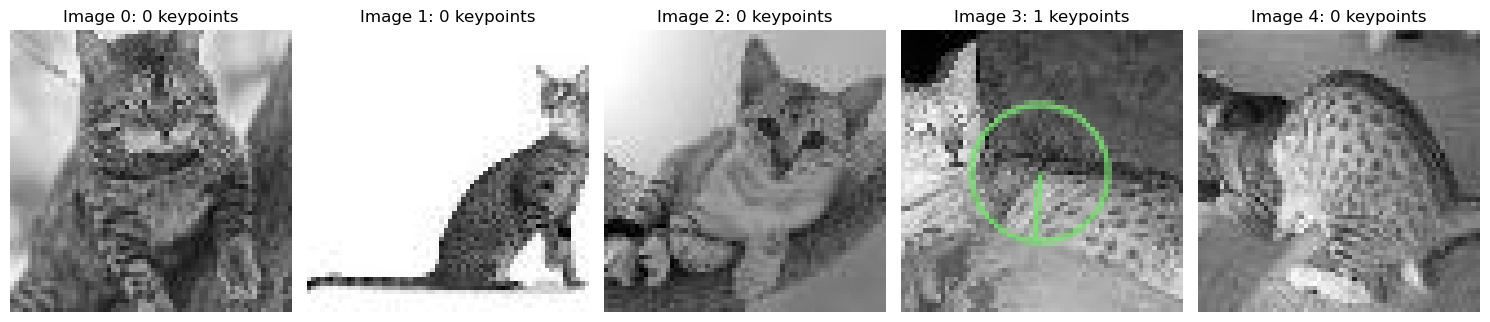

Encoding images with SIFT: 100%|██████████| 1500/1500 [00:01<00:00, 1371.32it/s]


Visualizing SIFT keypoints for a few training images...


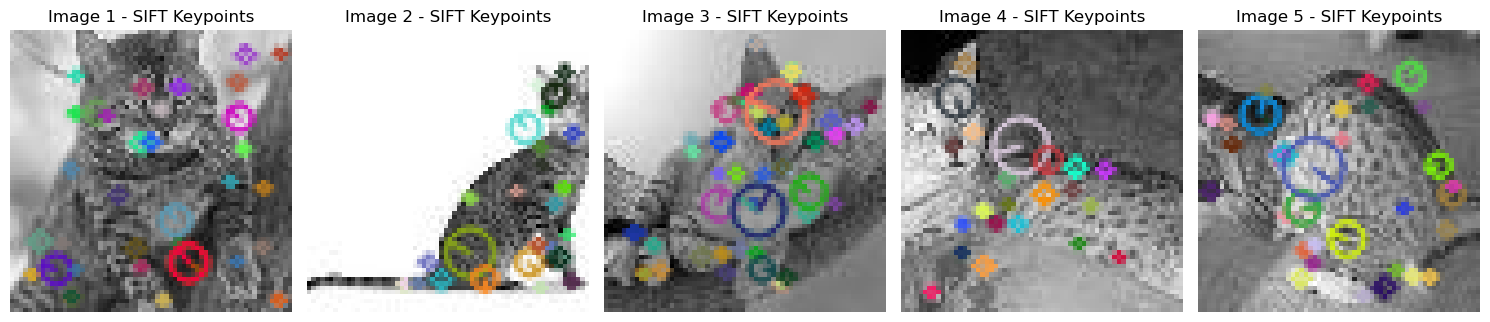

Visualizing BoW histograms for a few training images using SIFT...


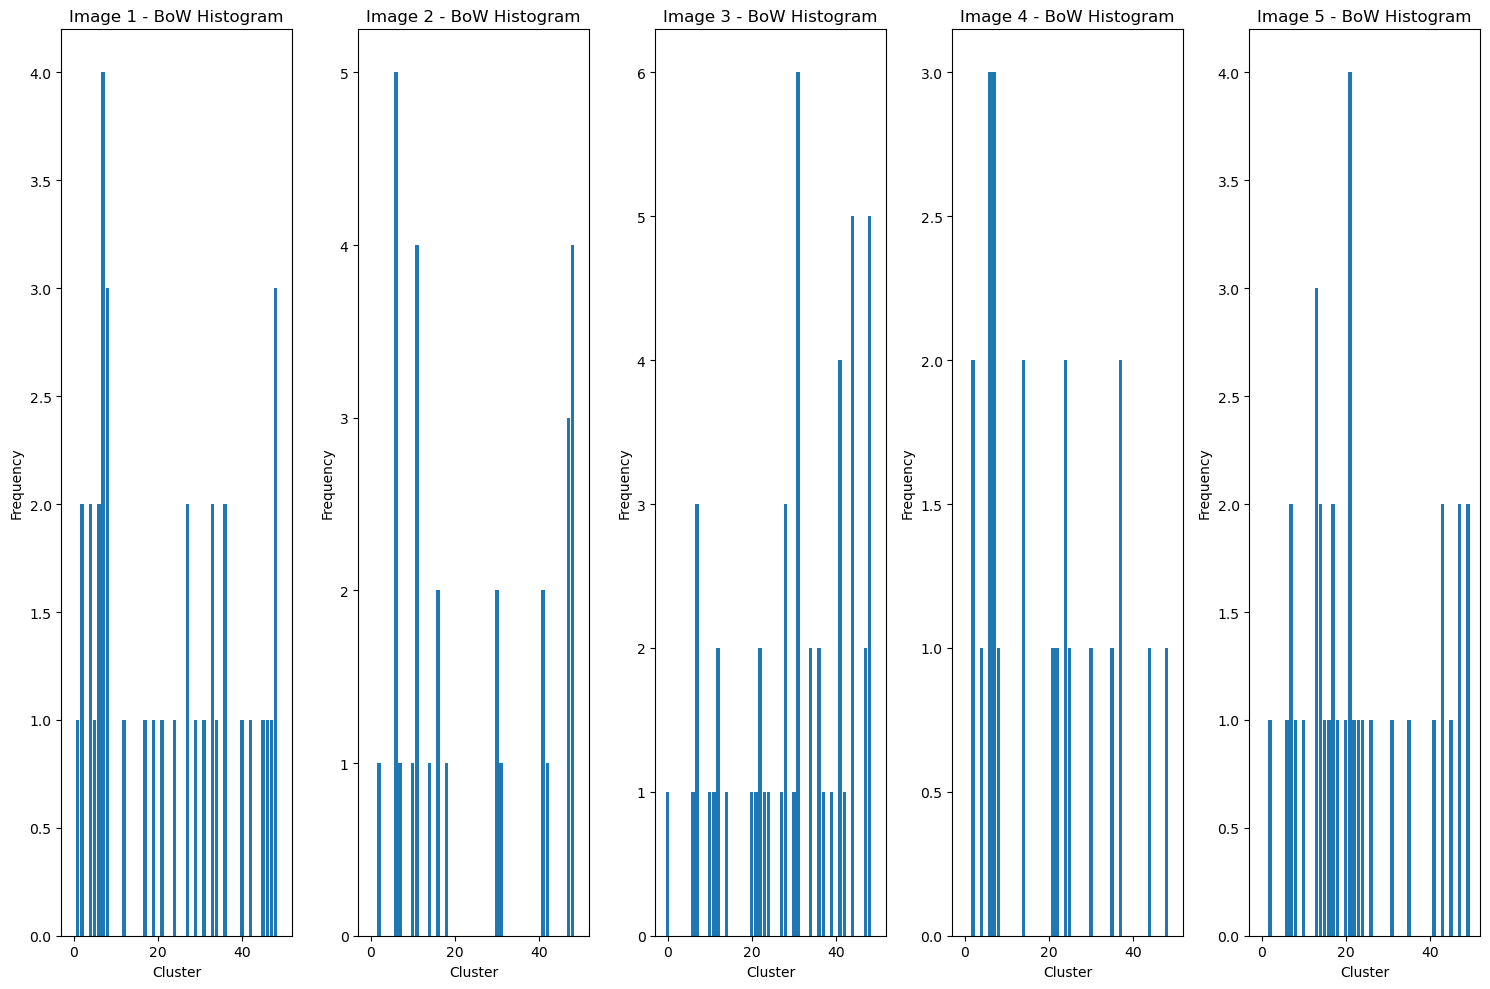

Selected Labels: ['Labrador retriever', 'sea slug, nudibranch', 'cliff dwelling', 'Persian cat', 'mantis, mantid', 'sulphur butterfly, sulfur butterfly', 'binoculars, field glasses, opera glasses', 'CD player', 'beacon, lighthouse, beacon light, pharos', 'Egyptian cat', 'bison', 'convertible', 'sea cucumber, holothurian', 'brass, memorial tablet, plaque', 'abacus']
Training SVM...
Classification Report:
                                          precision    recall  f1-score   support

                      Labrador retriever       0.16      0.06      0.09       100
                    sea slug, nudibranch       0.21      0.06      0.09       100
                          cliff dwelling       0.16      0.13      0.14       100
                             Persian cat       0.18      0.29      0.22       100
                          mantis, mantid       0.24      0.34      0.28       100
     sulphur butterfly, sulfur butterfly       0.18      0.32      0.23       100
binoculars, field 

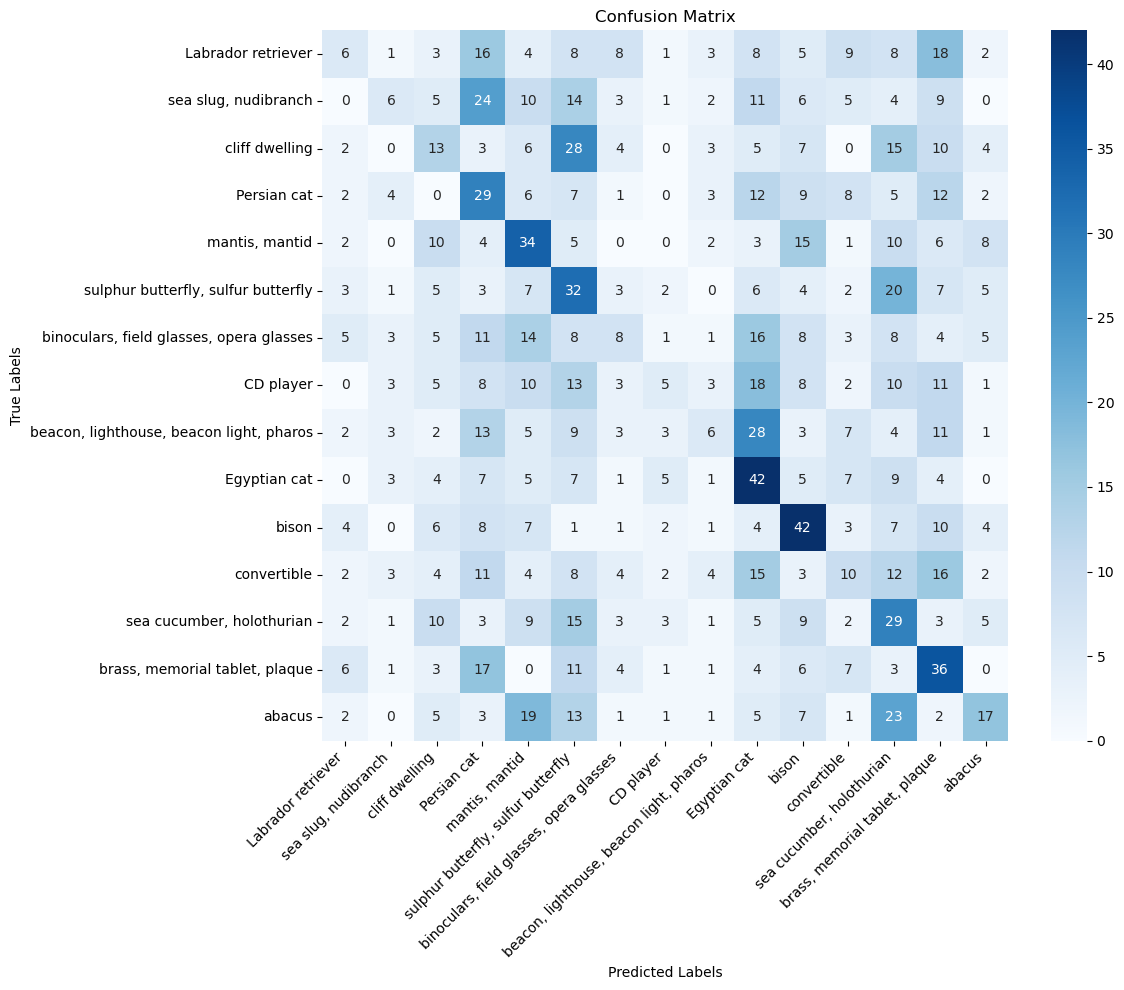


Running workflow using ORB and BoW...


Extracting ORB features: 100%|████████████| 1500/1500 [00:00<00:00, 5592.61it/s]


Visualizing ORB keypoints for a few training images...


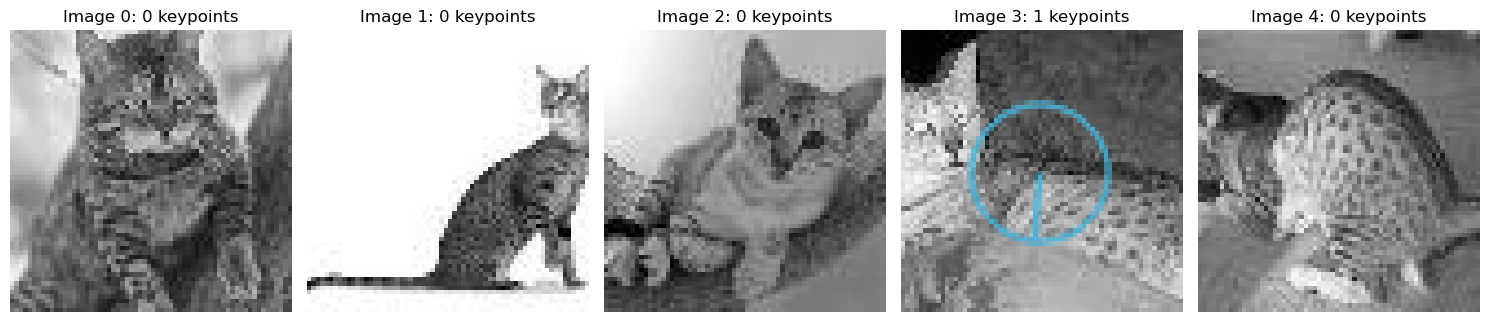

Encoding images with ORB: 100%|███████████| 1500/1500 [00:00<00:00, 6144.44it/s]


Visualizing ORB keypoints for a few training images...


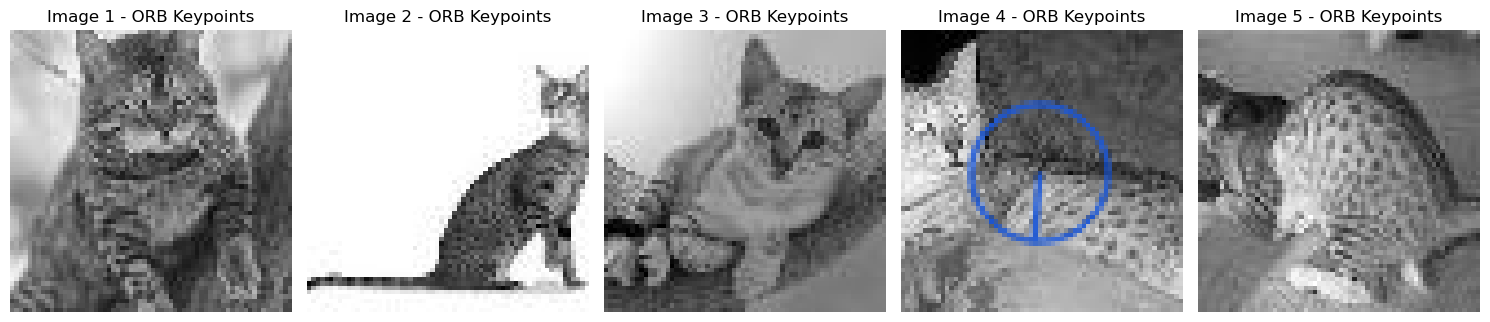

Visualizing BoW histograms for a few training images using ORB...


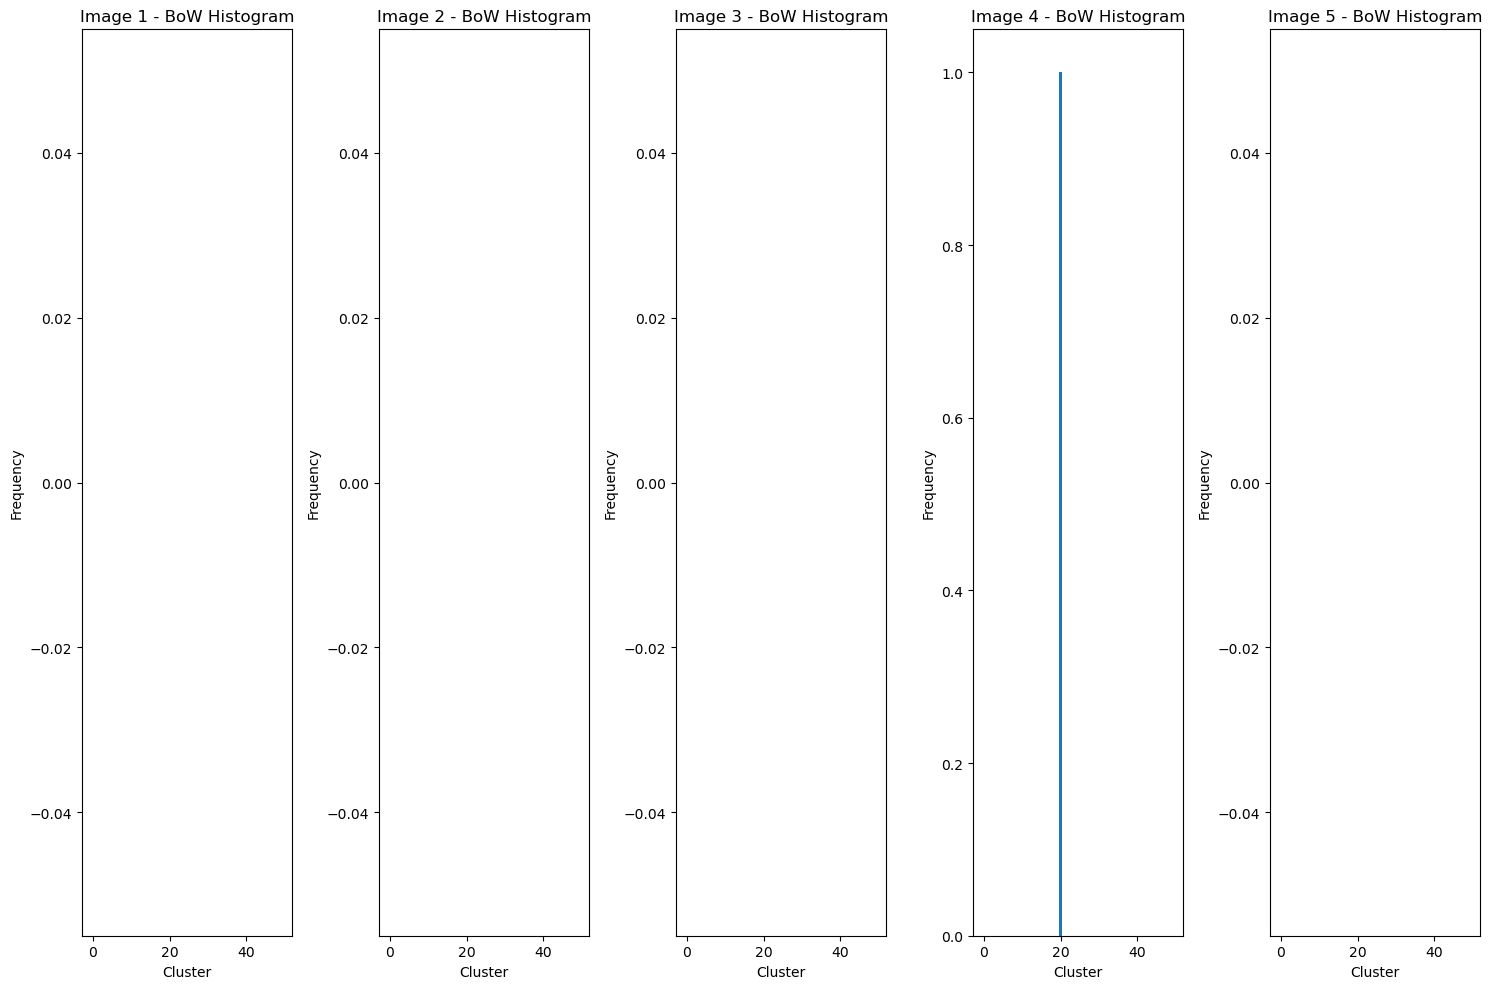

Selected Labels: ['Labrador retriever', 'sea slug, nudibranch', 'cliff dwelling', 'Persian cat', 'mantis, mantid', 'sulphur butterfly, sulfur butterfly', 'binoculars, field glasses, opera glasses', 'CD player', 'beacon, lighthouse, beacon light, pharos', 'Egyptian cat', 'bison', 'convertible', 'sea cucumber, holothurian', 'brass, memorial tablet, plaque', 'abacus']
Training SVM...
Classification Report:
                                          precision    recall  f1-score   support

                      Labrador retriever       0.07      0.02      0.03       100
                    sea slug, nudibranch       0.00      0.00      0.00       100
                          cliff dwelling       0.07      0.02      0.03       100
                             Persian cat       0.20      0.01      0.02       100
                          mantis, mantid       0.04      0.01      0.02       100
     sulphur butterfly, sulfur butterfly       0.08      0.90      0.14       100
binoculars, field 

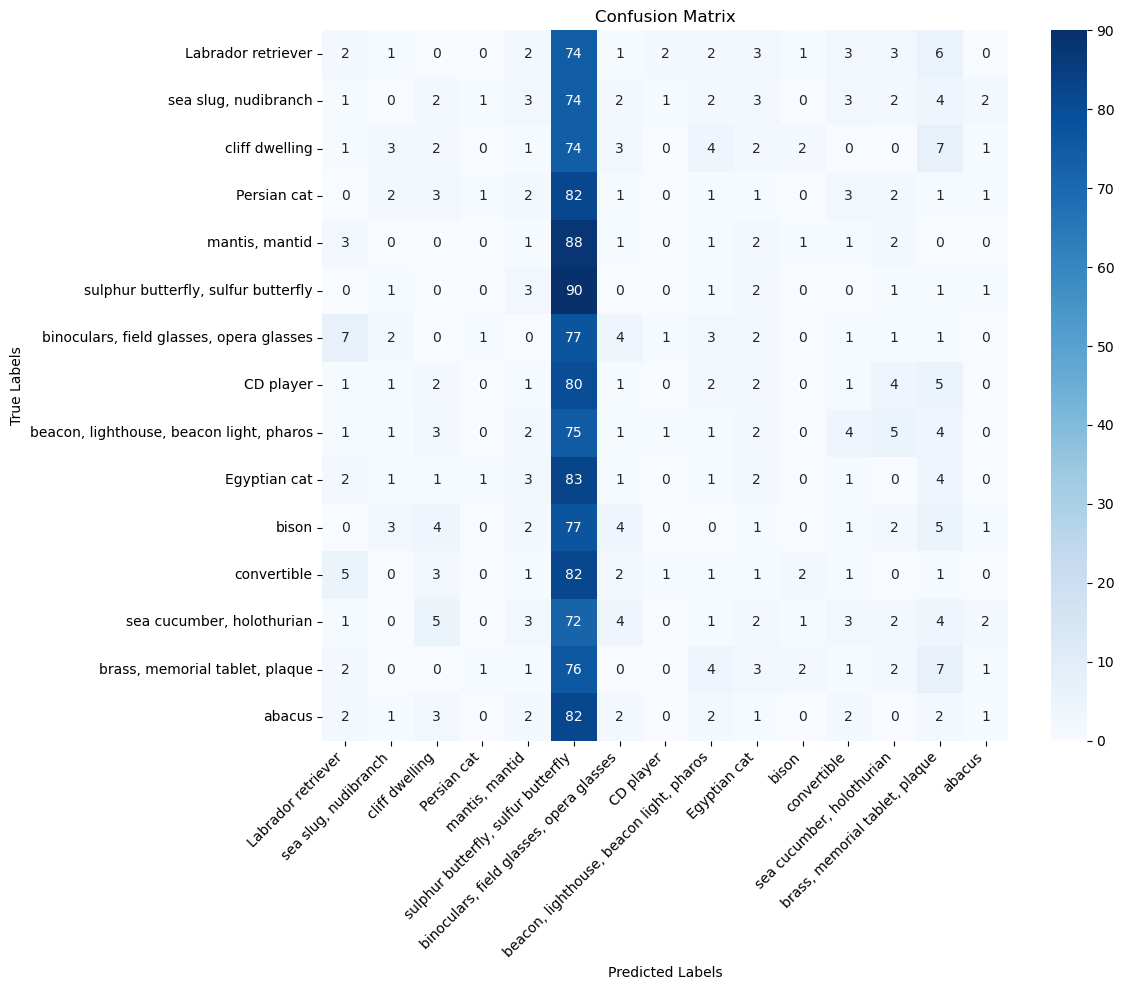

In [119]:
# BoW workflow
for method in ["SIFT", "ORB"]:
    print(f"\nRunning workflow using {method} and BoW...")
    descriptors_train = extract_features_sift(train_image_paths) if method == "SIFT" else extract_features_orb1(train_image_paths)
    descriptors_test = extract_features_sift(test_image_paths) if method == "SIFT" else extract_features_orb1(test_image_paths)


        # Visualize ORB Keypoints for a few images
    print("Visualizing ORB keypoints for a few training images...")
    visualize_orb_keypoints_debug(train_image_paths, num_images=5)
    
    kmeans = build_bow(descriptors_train, num_clusters=50)
    X_train = encode_features(train_image_paths, kmeans, method=method)
    X_test = encode_features(test_image_paths, kmeans, method=method)
    
     # Visualize SIFT Keypoints for SIFT method
    if method == "SIFT":
        print("Visualizing SIFT keypoints for a few training images...")
        visualize_sift_keypoints(train_image_paths, num_images=5)
    else:
    # Visualize ORB Keypoints
        print("Visualizing ORB keypoints for a few training images...")
        visualize_orb_keypoints(train_image_paths, num_images=5)

    # Visualize BoW Histograms
    print(f"Visualizing BoW histograms for a few training images using {method}...")
    visualize_bow_histograms(train_image_paths, kmeans, num_images=5, method=method)
   

    train_and_evaluate_svm(X_train, X_test, y_train, y_test, class_dict, selected_classes)

# Fisher Vector(for middle level features)

In [121]:
# ---------------------
# Fisher Vector
# ---------------------

def train_fisher_gmm(descriptors_list, num_clusters):
    """
    Train a Gaussian Mixture Model (GMM) for Fisher Vector computation.
    Filters descriptors with incorrect dimensions.
    """
    # Filter valid descriptors (with dimension 128)
    valid_descriptors = [desc for desc in descriptors_list if desc is not None and desc.shape[1] == 128]
    if len(valid_descriptors) == 0:
        raise ValueError("No valid descriptors found. Check your dataset or feature extraction process.")

    # Stack valid descriptors
    all_descriptors = np.vstack(valid_descriptors).astype(np.float32)
    print(f"Training GMM with {all_descriptors.shape[0]} descriptors of dimension {all_descriptors.shape[1]}...")
    
    # Train GMM
    gmm = GaussianMixture(n_components=num_clusters, covariance_type="diag", random_state=42, max_iter=100)
    gmm.fit(all_descriptors)
    return gmm

def compute_fisher_vector(descriptors_list, gmm):
    """
    Compute Fisher Vector representation for a list of descriptors using a GMM model.
    Assign zero vectors for missing descriptors.
    """
    fisher_vectors = []
    zero_vector = np.zeros(gmm.n_components * 2 * gmm.means_.shape[1])  # Zero vector for missing descriptors
    for descriptors in tqdm(descriptors_list, desc="Computing Fisher Vectors"):
        if descriptors is None or len(descriptors) == 0:
            fisher_vectors.append(zero_vector)  # Assign a zero vector for missing descriptors
        else:
            fisher_vector = np.hstack([
                np.sum((descriptors - mean) / cov, axis=0)
                for mean, cov in zip(gmm.means_, gmm.covariances_)
            ])

# Fisher Vector(for middle level features) + SIFT(for local image features)

Extracting SIFT features...


Testing descriptors: 100%|████████████████| 1500/1500 [00:01<00:00, 1411.16it/s]


Training GMM for Fisher Vector...
Training GMM with 219629 descriptors of dimension 128...
Computing Fisher Vectors...


Computing Fisher Vectors: 100%|███████████| 1499/1499 [00:00<00:00, 2779.77it/s]


Normalizing Fisher Vectors...
Applying PCA to reduce dimensionality...
Training SVM...
Evaluating SVM...
Classification Report:
                                        precision    recall  f1-score   support

                    Labrador retriever       0.00      0.00      0.00       100
                   sea slug nudibranch       0.10      0.03      0.05       100
                        cliff dwelling       0.19      0.31      0.24        99
                           Persian cat       0.21      0.20      0.21       100
                         mantis mantid       0.18      0.43      0.25       100
    sulphur butterfly sulfur butterfly       0.06      0.03      0.04       100
binoculars field glasses opera glasses       0.14      0.14      0.14       100
                             CD player       0.00      0.00      0.00       100
 beacon lighthouse beacon light pharos       0.09      0.03      0.05       100
                          Egyptian cat       0.15      0.25      0.19  

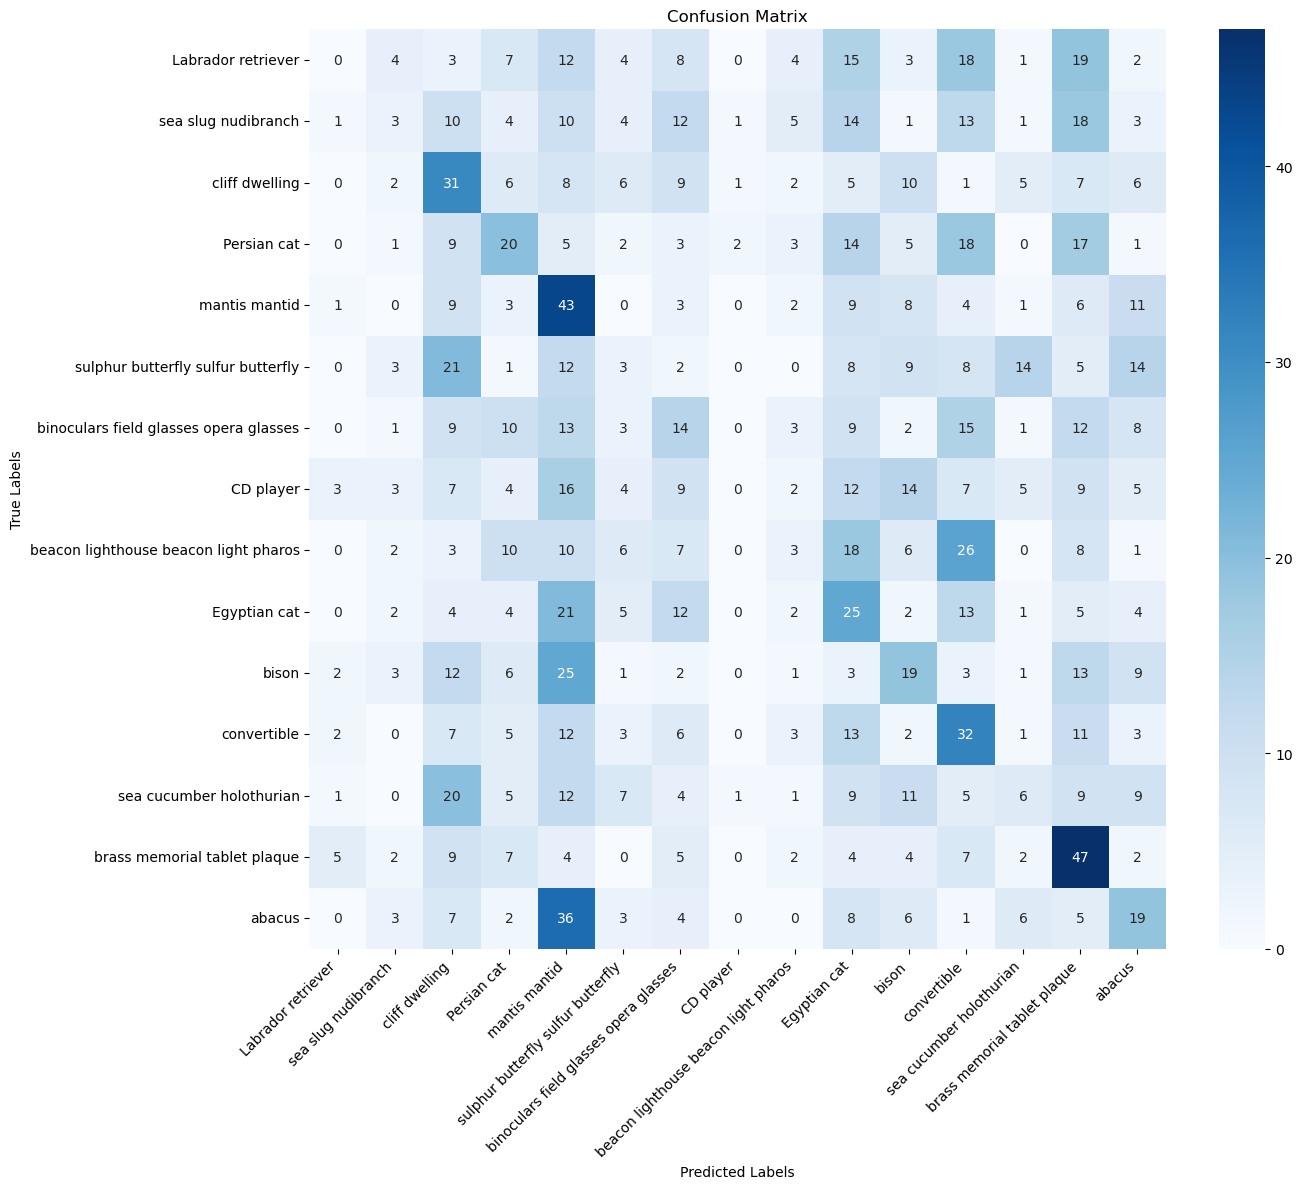

In [123]:
from sklearn.preprocessing import normalize
def train_and_evaluate_fisher_vector_sift(train_image_paths, test_image_paths, y_train, y_test, class_dict, selected_classes):
    """
    Simplified workflow for Fisher Vector with SIFT and SVM evaluation.
    """
    print("Extracting SIFT features...")
    sift = cv2.SIFT_create()

    descriptors_train = [
        sift.detectAndCompute(cv2.imread(img, cv2.IMREAD_GRAYSCALE), None)[1]
        for img in tqdm(train_image_paths, desc="Training descriptors")
    ]
    descriptors_test = [
        sift.detectAndCompute(cv2.imread(img, cv2.IMREAD_GRAYSCALE), None)[1]
        for img in tqdm(test_image_paths, desc="Testing descriptors")
    ]

    # Filter valid descriptors and corresponding labels for train and test
    valid_descriptors_train, filtered_labels_train = [], []
    for desc, label in zip(descriptors_train, y_train):
        if desc is not None and len(desc) > 0:
            valid_descriptors_train.append(desc)
            filtered_labels_train.append(label)

    valid_descriptors_test, filtered_labels_test = [], []
    for desc, label in zip(descriptors_test, y_test):
        if desc is not None and len(desc) > 0:
            valid_descriptors_test.append(desc)
            filtered_labels_test.append(label)

    descriptors_train = valid_descriptors_train
    descriptors_test = valid_descriptors_test
    y_train = np.array(filtered_labels_train)
    y_test = np.array(filtered_labels_test)

    print("Training GMM for Fisher Vector...")
    gmm = train_fisher_gmm(descriptors_train, num_clusters=30)

    print("Computing Fisher Vectors...")
    fv_train = compute_fisher_vector(descriptors_train, gmm)
    fv_test = compute_fisher_vector(descriptors_test, gmm)

    print("Normalizing Fisher Vectors...")
    fv_train = normalize(fv_train, norm='l2')
    fv_test = normalize(fv_test, norm='l2')

    print("Applying PCA to reduce dimensionality...")
    pca = PCA(n_components=500)
    fv_train_reduced = pca.fit_transform(fv_train)
    fv_test_reduced = pca.transform(fv_test)

    # Add placeholder samples for missing classes
    for cls in range(len(selected_classes)):
        if cls not in y_train:
            print(f"Adding placeholder for missing class {cls} in training set.")
            y_train = np.append(y_train, cls)
            fv_train_reduced = np.vstack([fv_train_reduced, np.zeros_like(fv_train_reduced[0])])

        if cls not in y_test:
            print(f"Adding placeholder for missing class {cls} in testing set.")
            y_test = np.append(y_test, cls)
            fv_test_reduced = np.vstack([fv_test_reduced, np.zeros_like(fv_test_reduced[0])])

    print("Training SVM...")
    svm = LinearSVC(random_state=42, max_iter=10000)
    svm.fit(fv_train_reduced, y_train)

    print("Evaluating SVM...")
    predictions = svm.predict(fv_test_reduced)

    # Dynamically ensure all selected labels are included
    filtered_labels = [" ".join(class_dict[selected_classes[idx]]) for idx in range(len(selected_classes))]

    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=filtered_labels))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=filtered_labels, yticklabels=filtered_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

def train_fisher_gmm(descriptors_list, num_clusters):
    """
    Train a Gaussian Mixture Model (GMM) for Fisher Vector computation.
    """
    valid_descriptors = [desc for desc in descriptors_list if desc is not None]
    if len(valid_descriptors) == 0:
        raise ValueError("No valid descriptors found. Check your dataset or feature extraction process.")

    # Stack valid descriptors
    all_descriptors = np.vstack(valid_descriptors).astype(np.float32)
    print(f"Training GMM with {all_descriptors.shape[0]} descriptors of dimension {all_descriptors.shape[1]}...")

    gmm = GaussianMixture(n_components=num_clusters, covariance_type="diag", random_state=42, max_iter=500)
    gmm.fit(all_descriptors)
    return gmm

def compute_fisher_vector(descriptors_list, gmm):
    """
    Compute Fisher Vector representation for a list of descriptors using a GMM model.
    """
    fisher_vectors = []
    zero_vector = np.zeros(gmm.n_components * 2 * gmm.means_.shape[1])  # Zero vector for missing descriptors
    for descriptors in tqdm(descriptors_list, desc="Computing Fisher Vectors"):
        if descriptors is None or len(descriptors) == 0:
            fisher_vectors.append(zero_vector)
        else:
            fisher_vector = np.hstack([
                np.sum((descriptors - mean) / np.sqrt(cov + 1e-8), axis=0)
                for mean, cov in zip(gmm.means_, gmm.covariances_)
            ])
            fisher_vectors.append(fisher_vector)
    return np.array(fisher_vectors)

# Example usage:
train_and_evaluate_fisher_vector_sift(train_image_paths, test_image_paths, y_train, y_test, class_dict, selected_classes)


# Fisher Vector(for middle level features) + ORB(for local image features)

Extracting ORB features...


Testing descriptors: 100%|████████████████| 1500/1500 [00:00<00:00, 5408.70it/s]


Training GMM for Fisher Vector...
Training GMM with 1321 descriptors of dimension 32...
Computing Fisher Vectors...


Computing Fisher Vectors: 100%|█████████████| 314/314 [00:00<00:00, 7404.43it/s]


Normalizing Fisher Vectors...
Applying PCA to reduce dimensionality...
Training SVM...
Evaluating SVM...
Classification Report:
                                        precision    recall  f1-score   support

                    Labrador retriever       0.33      0.04      0.07        26
                   sea slug nudibranch       0.03      0.04      0.03        26
                        cliff dwelling       0.06      0.08      0.07        26
                           Persian cat       0.08      0.06      0.07        18
                         mantis mantid       0.00      0.00      0.00        12
    sulphur butterfly sulfur butterfly       0.00      0.00      0.00        10
binoculars field glasses opera glasses       0.06      0.09      0.07        23
                             CD player       0.00      0.00      0.00        20
 beacon lighthouse beacon light pharos       0.00      0.00      0.00        25
                          Egyptian cat       0.08      0.12      0.09  

/Users/hinaghazanfar/Documents/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hinaghazanfar/Documents/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hinaghazanfar/Documents/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

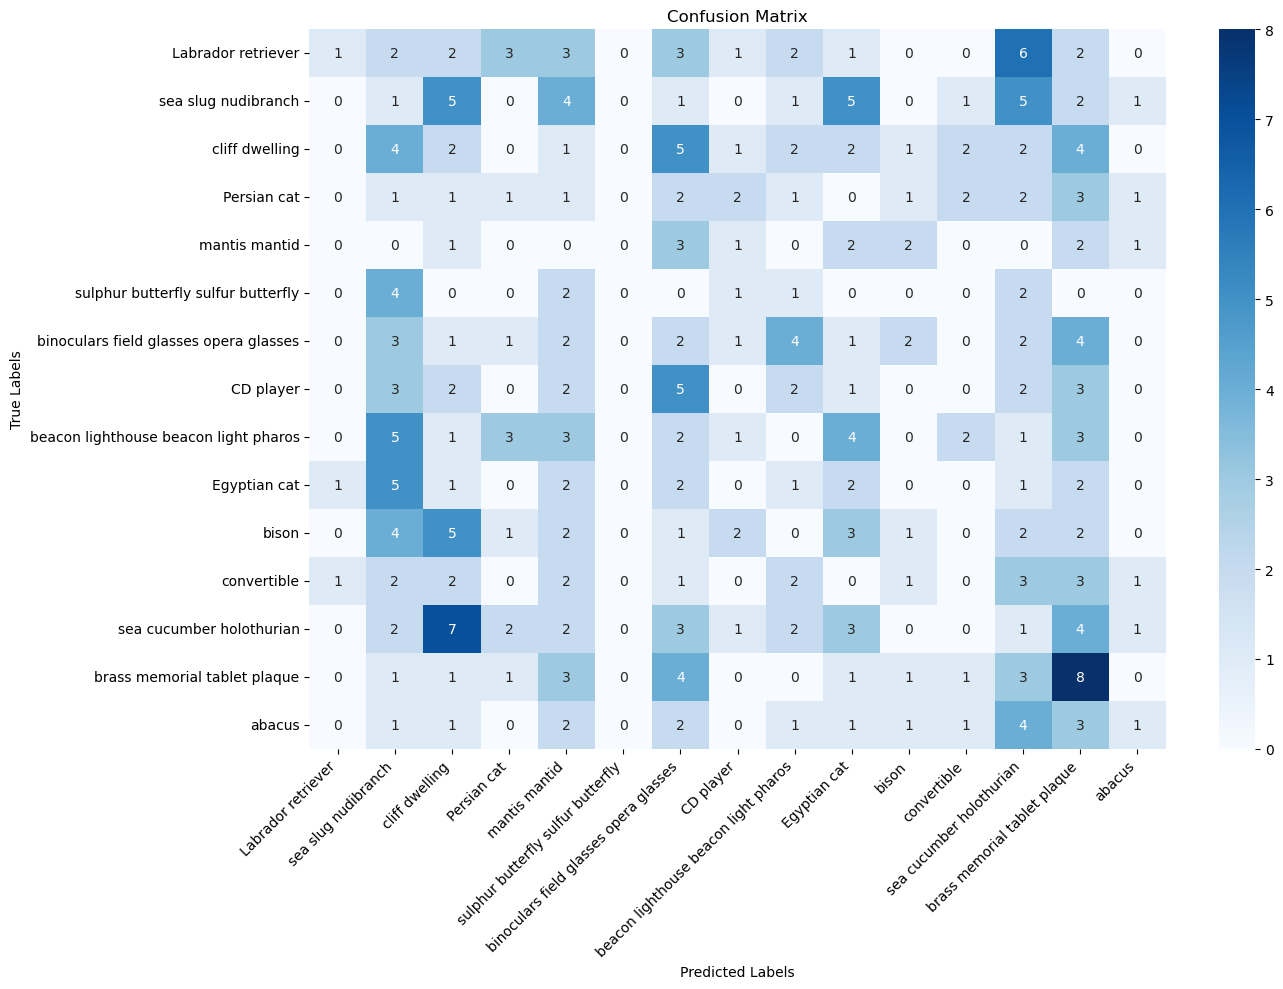

In [125]:

def train_and_evaluate_fisher_vector_orb(train_image_paths, test_image_paths, y_train, y_test, class_dict, selected_classes):
    """
    Workflow for Fisher Vector with ORB and SVM evaluation.
    """
    print("Extracting ORB features...")
    orb = cv2.ORB_create(nfeatures=500)

    descriptors_train = [
        orb.detectAndCompute(cv2.imread(img, cv2.IMREAD_GRAYSCALE), None)[1]
        for img in tqdm(train_image_paths, desc="Training descriptors")
    ]
    descriptors_test = [
        orb.detectAndCompute(cv2.imread(img, cv2.IMREAD_GRAYSCALE), None)[1]
        for img in tqdm(test_image_paths, desc="Testing descriptors")
    ]

    # Filter valid descriptors and corresponding labels for train and test
    valid_descriptors_train, filtered_labels_train = [], []
    for desc, label in zip(descriptors_train, y_train):
        if desc is not None and len(desc) > 0:
            valid_descriptors_train.append(desc)
            filtered_labels_train.append(label)

    valid_descriptors_test, filtered_labels_test = [], []
    for desc, label in zip(descriptors_test, y_test):
        if desc is not None and len(desc) > 0:
            valid_descriptors_test.append(desc)
            filtered_labels_test.append(label)

    descriptors_train = valid_descriptors_train
    descriptors_test = valid_descriptors_test
    y_train = np.array(filtered_labels_train)
    y_test = np.array(filtered_labels_test)

    print("Training GMM for Fisher Vector...")
    gmm = train_fisher_gmm(descriptors_train, num_clusters=30)

    print("Computing Fisher Vectors...")
    fv_train = compute_fisher_vector(descriptors_train, gmm)
    fv_test = compute_fisher_vector(descriptors_test, gmm)

    print("Normalizing Fisher Vectors...")
    fv_train = normalize(fv_train, norm='l2')
    fv_test = normalize(fv_test, norm='l2')

    print("Applying PCA to reduce dimensionality...")
    pca = PCA(n_components=500)
    fv_train_reduced = pca.fit_transform(fv_train)
    fv_test_reduced = pca.transform(fv_test)

    # Add placeholder samples for missing classes
    for cls in range(len(selected_classes)):
        if cls not in y_train:
            print(f"Adding placeholder for missing class {cls} in training set.")
            y_train = np.append(y_train, cls)
            fv_train_reduced = np.vstack([fv_train_reduced, np.zeros_like(fv_train_reduced[0])])

        if cls not in y_test:
            print(f"Adding placeholder for missing class {cls} in testing set.")
            y_test = np.append(y_test, cls)
            fv_test_reduced = np.vstack([fv_test_reduced, np.zeros_like(fv_test_reduced[0])])

    print("Training SVM...")
    svm = LinearSVC(random_state=42, max_iter=10000)
    svm.fit(fv_train_reduced, y_train)

    print("Evaluating SVM...")
    predictions = svm.predict(fv_test_reduced)

    # Dynamically ensure all selected labels are included
    filtered_labels = [" ".join(class_dict[selected_classes[idx]]) for idx in range(len(selected_classes))]

    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=filtered_labels))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=filtered_labels, yticklabels=filtered_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()





def train_fisher_gmm(descriptors_list, num_clusters):
    """
    Train a Gaussian Mixture Model (GMM) for Fisher Vector computation.
    """
    valid_descriptors = [desc for desc in descriptors_list if desc is not None]
    if len(valid_descriptors) == 0:
        raise ValueError("No valid descriptors found. Check your dataset or feature extraction process.")

    # Stack valid descriptors
    all_descriptors = np.vstack(valid_descriptors).astype(np.float32)
    print(f"Training GMM with {all_descriptors.shape[0]} descriptors of dimension {all_descriptors.shape[1]}...")

    gmm = GaussianMixture(n_components=num_clusters, covariance_type="diag", random_state=42, max_iter=500)
    gmm.fit(all_descriptors)
    return gmm

def compute_fisher_vector(descriptors_list, gmm):
    """
    Compute Fisher Vector representation for a list of descriptors using a GMM model.
    """
    fisher_vectors = []
    zero_vector = np.zeros(gmm.n_components * 2 * gmm.means_.shape[1])  # Zero vector for missing descriptors
    for descriptors in tqdm(descriptors_list, desc="Computing Fisher Vectors"):
        if descriptors is None or len(descriptors) == 0:
            fisher_vectors.append(zero_vector)
        else:
            fisher_vector = np.hstack([
                np.sum((descriptors - mean) / np.sqrt(cov + 1e-8), axis=0)
                for mean, cov in zip(gmm.means_, gmm.covariances_)
            ])
            fisher_vectors.append(fisher_vector)
    return np.array(fisher_vectors)

# Example usage:
# Replace these placeholders with actual data
# train_image_paths = ["path_to_train_image1", "path_to_train_image2", ...]
# test_image_paths = ["path_to_test_image1", "path_to_test_image2", ...]
# y_train = [0, 1, ...]  # Labels for training images
# y_test = [0, 1, ...]   # Labels for testing images
# class_dict = {0: ["class0"], 1: ["class1"], ...}
# selected_classes = [0, 1, ...]

train_and_evaluate_fisher_vector_orb(train_image_paths, test_image_paths, y_train, y_test, class_dict, selected_classes)


# Note: Scroll down above output pane for results.